In [1]:
# Install the timm library (PyTorch Image Models) for access to various SOTA vision models
!pip install timm

# Core PyTorch library for tensor computations and neural networks
import torch

# torchvision: utilities for computer vision tasks (datasets, image transforms, etc.)
from torchvision import datasets, transforms

# defaultdict: a dict subclass that provides default values for missing keys
from collections import defaultdict

# datetime: for date and time manipulation
import datetime

# PyTorch data loading utilities for creating subsets and data loaders
from torch.utils.data import Subset, DataLoader, SubsetRandomSampler

# numpy: numerical computing library for arrays and math functions
import numpy as np

# random: utilities for random number generation
import random

# copy: provides deep and shallow copy operations
import copy

# torch.nn: PyTorch neural network building blocks (layers, activations, etc.)
import torch.nn as nn

# timm: PyTorch Image Models, a collection of pre-trained computer vision models
import timm

# matplotlib.pyplot: plotting interface for creating figures and plots
import matplotlib.pyplot as plt

# seaborn: statistical data visualization (built on matplotlib)
import seaborn as sns

# scikit-learn metrics for model evaluation (e.g., confusion matrix)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# torch.optim: PyTorch optimization algorithms (e.g., SGD, Adam, etc.)
import torch.optim as optim

# os: operating system interfaces for file and directory management
import os

# Google Colab specific: for mounting Google Drive to save/load files
from google.colab import drive

# Re-importing defaultdict (redundant, already imported above)
from collections import defaultdict

# itertools: utilities for efficient looping (e.g., cartesian products, permutations)
import itertools

# time: time-related functions (e.g., measuring code execution time)
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Mount Google Drive to access files (force_remount ensures fresh mount)
drive.mount('/content/drive', force_remount=True)
class Config:
    # Hardware & Paths
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    GOOGLE_DRIVE = '/content/drive/MyDrive/federated_model_editing'
    CHECKPOINT_DIR = f"{GOOGLE_DRIVE}/checkpoints"
    LOG_DIR = f"{GOOGLE_DRIVE}/logs"
    FIGURE_DIR = f"{GOOGLE_DRIVE}/figures"
    RANDOM_SEED = 42

    # Dataset
    DATASET = 'CIFAR100'
    NUM_CLASSES = 100
    VAL_SPLIT = 0.1
    BATCH_SIZE = 64

    # Model
    MODEL_NAME = 'vit_small_patch16_224'

    # Centralized Training
    EPOCHS_CENTRALIZED = 10 #per experiment
    LR = 0.03
    MOMENTUM = 0.9
    WEIGHT_DECAY = 5e-4

    # Federated Learning
    NUM_CLIENTS = 100
    EPOCHS_FEDAVG = 50
    LOCAL_EPOCHS = 5
    CLIENT_FRACTION = 0.1

    # Sparse/Masking
    SPARSE_RATIO = 0.5
    NC = 10  # Default non-iid classes per client

    # Others
    NUM_WORKERS = 2
    PIN_MEMORY = True

Mounted at /content/drive


In [3]:
def get_transforms():
    """
    Standardized data transformations for CIFAR-100, resized for ViT input.
    Returns:
        tuple: (transform_train, transform_test)
        - transform_train: Data augmentation for training set.
        - transform_test: Standard preprocessing for test/validation set.
    """
    # Mean and std values for CIFAR-100 normalization (RGB channels)
    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)
    # Training data transformations (augmentation + normalization)
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),              # Resize images to 224x224 (ViT input size)
        transforms.RandomHorizontalFlip(),          # Randomly flip images horizontally
        transforms.RandomRotation(15),              # Randomly rotate images within ±15°
        transforms.ToTensor(),                      # Convert PIL Image or numpy.ndarray to tensor
        transforms.Normalize(mean, std),            # Normalize to dataset mean and std
    ])
    # Test/Validation data transformations (no augmentation, only normalization)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),              # Resize to 224x224
        transforms.ToTensor(),                      # Convert to tensor
        transforms.Normalize(mean, std),            # Normalize
    ])
    return transform_train, transform_test

def split_dataset(dataset, val_split=0.1, seed=42):
    """
    Split dataset into training and validation subsets.
    Args:
        dataset: PyTorch Dataset to split.
        val_split (float): Proportion of data to use for validation.
        seed (int): Random seed for reproducibility.
    Returns:
        tuple: (train_subset, val_subset)
    """
    np.random.seed(seed)
    indices = np.arange(len(dataset))           # All sample indices
    np.random.shuffle(indices)                  # Shuffle indices
    val_size = int(len(dataset) * val_split)    # Number of validation samples
    val_indices = indices[:val_size]            # First part: validation indices
    train_indices = indices[val_size:]          # Remainder: training indices
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

def iid_shard(dataset, num_clients):
    """
    IID partitioning: Equal-sized random shards per client.
    Args:
        dataset: Dataset or Subset to partition.
        num_clients (int): How many clients to create.
    Returns:
        list: List of indices assigned to each client.
    """
    data_per_client = len(dataset) // num_clients           # Shard size per client
    indices = np.arange(len(dataset))                       # All indices
    np.random.shuffle(indices)                              # Shuffle for randomness
    # Divide indices equally among all clients
    return [
        indices[i * data_per_client : (i + 1) * data_per_client]
        for i in range(num_clients)
    ]

def noniid_shard(dataset, num_clients, nc=1):
    """
    Non-IID partitioning: Each client gets data from nc classes only.
    Args:
        dataset: Dataset or Subset to partition.
        num_clients (int): Number of clients.
        nc (int): Number of classes per client.
    Returns:
        list: List of indices per client (non-iid).
    """
    # Handle Subset (common in federated learning) or original Dataset
    if isinstance(dataset, Subset):
        # For Subset, map indices to original dataset labels
        labels = np.array(dataset.dataset.targets)[dataset.indices]
    else:
        labels = np.array(dataset.targets)
    num_classes = len(np.unique(labels))                # Total unique classes
    # Indices for each class
    idx_by_class = [np.where(labels == i)[0] for i in range(num_classes)]
    client_indices = [[] for _ in range(num_clients)]   # Output: indices per client
    # Randomly assign nc classes per client (without replacement)
    classes_per_client = [
        np.random.choice(num_classes, nc, replace=False)
        for _ in range(num_clients)
    ]
    # For each client, assign samples from selected classes
    for client_id, client_classes in enumerate(classes_per_client):
        for c in client_classes:
            cnt = len(idx_by_class[c]) // num_clients   # Fair split from class c
            chosen = idx_by_class[c][:cnt]              # Take cnt samples for this client
            idx_by_class[c] = idx_by_class[c][cnt:]     # Remove assigned samples
            client_indices[client_id].extend(chosen.tolist())
    return client_indices

def get_dataloaders(config, iid=True, nc=10):
    """
    Create federated dataloaders: per-client, validation, and test.
    Args:
        config: Configuration object/namespace with dataset and dataloader params.
        iid (bool): If True, use IID partitioning; else, use non-IID.
        nc (int): Number of classes per client (used only if iid=False).
    Returns:
        tuple: (list of client DataLoaders, validation DataLoader, test DataLoader)
    """
    # Get standardized transformations for train/test
    transform_train, transform_test = get_transforms()
    # Download and process CIFAR-100 datasets
    trainset = datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train
    )
    testset = datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test
    )
    # Split training set into train and validation sets
    trainset, valset = split_dataset(trainset, val_split=config.VAL_SPLIT)
    # Partition training set indices for clients (IID or non-IID)
    shards = (
        iid_shard(trainset, config.NUM_CLIENTS)
        if iid else noniid_shard(trainset, config.NUM_CLIENTS, nc)
    )
    # Create DataLoader for each client shard
    clients_loaders = [
        DataLoader(
            trainset,
            batch_size=config.BATCH_SIZE,
            sampler=SubsetRandomSampler(idxs),
            num_workers=config.NUM_WORKERS,
            pin_memory=config.PIN_MEMORY
        )
        for idxs in shards
    ]
    # DataLoader for validation set (no shuffling)
    val_loader = DataLoader(
        valset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY
    )
    # DataLoader for test set (no shuffling)
    test_loader = DataLoader(
        testset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY
    )
    return clients_loaders, val_loader, test_loader

In [4]:
class ViTSmallDINO(nn.Module):
    """Vision Transformer (ViT) model with DINO-pretrained weights.

    This class implements a small Vision Transformer (ViT-S/16) using pretrained weights
    from DINO (self-supervised learning). The model consists of:
    - A DINO-pretrained ViT backbone
    - A custom linear classification head

    Args:
        num_classes (int): Number of output classes for classification (default: 100)
    """

    def __init__(self, num_classes=100):
        """Initialize the ViT model with DINO pretrained weights.

        Args:
            num_classes (int): Number of classes for the classification head
        """
        super().__init__()

        # Load pretrained ViT-S/16 model from timm with DINO weights
        # Patch size: 16x16, Image size: 224x224
        self.backbone = timm.create_model('vit_small_patch16_224', pretrained=True)

        # Replace the original head with a new linear layer for our task
        # in_features: Dimension of the backbone's output features
        # out_features: Number of target classes
        self.backbone.head = nn.Linear(self.backbone.head.in_features, num_classes)

    def forward(self, x):
        """Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, 224, 224)

        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes)
        """
        # Pass input through the backbone (ViT + classification head)
        return self.backbone(x)


def get_model(num_classes=100, device='cuda'):
    """Convenience function to create and configure the ViT-DINO model.

    Args:
        num_classes (int): Number of output classes (default: 100)
        device (str): Device to load the model onto ('cuda' or 'cpu') (default: 'cuda')

    Returns:
        ViTSmallDINO: Model instance moved to the specified device
    """
    # Initialize the ViT-DINO model with specified number of classes
    model = ViTSmallDINO(num_classes=num_classes)

    # Move model to the specified device (GPU if available)
    return model.to(device)

In [5]:
import torch
import torch.optim as optim

class SparseSGDM(optim.SGD):
    """Sparse Stochastic Gradient Descent with Momentum (SparseSGDM) optimizer.

    This optimizer extends PyTorch's SGD with support for gradient masking, enabling
    sparse parameter updates during training. Only parameters corresponding to non-zero
    values in the mask will be updated.

    Key Features:
    - Inherits all standard SGD functionality (momentum, weight decay)
    - Applies binary mask to gradients before parameter updates
    - Maintains original SGD performance for unmasked parameters
    - Device-aware mask application (automatically moves mask to parameter device)
    """

    def __init__(self, params, lr=0.01, momentum=0, weight_decay=0, mask=None):
        """
        Args:
            params (iterable): Iterable of parameters to optimize or dicts defining parameter groups
            lr (float): Learning rate (default: 0.01)
            momentum (float): Momentum factor (default: 0)
            weight_decay (float): Weight decay (L2 penalty) (default: 0)
            mask (list[Tensor], optional): List of binary masks (0/1) corresponding to
                parameter tensors. Must match parameter structure. None means no masking.
        """
        super().__init__(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
        self.mask = mask

    @torch.no_grad()
    def step(self, closure=None):
        """
        Performs a single optimization step with gradient masking.

        Args:
            closure (callable, optional): A closure that reevaluates the model and returns the loss.

        Returns:
            float: The computed loss if closure is provided, otherwise None

        Note:
            - Mask is applied BEFORE the standard SGD step calculation
            - Only parameters with non-None gradients are masked
            - Mask is automatically moved to the parameter's device
            - If mask is None, behaves exactly like standard SGD
        """
        # Apply gradient mask before the parameter update!
        if self.mask:
            for group in self.param_groups:
                for i, param in enumerate(group['params']):
                    if param.grad is not None and i < len(self.mask):
                        # Apply mask to the gradient, move mask to the same device as gradient
                        param.grad *= self.mask[i].to(param.grad.device)
        # Call the original SGD step function
        loss = super().step(closure)
        return loss

In [6]:
def average_weights(weights_list):
    """Compute element-wise average of multiple model state dictionaries.

    Args:
        weights_list (list[dict]): List of model state dictionaries to average

    Returns:
        dict: Averaged state dictionary with same structure as inputs
    """
    # Deep copy the first weights dictionary to initialize the average
    avg_weights = copy.deepcopy(weights_list[0])
    # Iterate over each key (parameter tensor name)
    for key in avg_weights.keys():
        # Accumulate weights from all other models
        for i in range(1, len(weights_list)):
            avg_weights[key] += weights_list[i][key]
        # Take the mean by dividing by number of models
        avg_weights[key] = torch.div(avg_weights[key], len(weights_list))
    return avg_weights

def fedavg_round(model, clients_loaders, config, train_fn, mask=None, device='cuda'):
    """Execute one communication round of Federated Averaging (FedAvg).

    Args:
        model (nn.Module): Global model to update
        clients_loaders (list[DataLoader]): List of client data loaders
        config (object): Configuration object (NUM_CLIENTS, CLIENT_FRACTION, LR, MOMENTUM, WEIGHT_DECAY, LOCAL_EPOCHS)
        train_fn (callable): Function to perform client training (model, loader, optimizer, criterion, device, mask)
        mask (list[Tensor], optional): Gradient mask for sparse training
        device (str): Device to use ('cuda' or 'cpu')

    Returns:
        nn.Module: Updated global model after aggregation
    """
    # Select a random subset of clients for this round
    num_selected = max(1, int(config.NUM_CLIENTS * config.CLIENT_FRACTION))
    selected_clients = random.sample(range(len(clients_loaders)), num_selected)
    client_weights = []

    for client_idx in selected_clients:
        # Deep copy the global model for local training
        local_model = copy.deepcopy(model)
        # Setup optimizer and loss criterion for local training
        optimizer = torch.optim.SGD(
            local_model.parameters(),
            lr=config.LR,
            momentum=config.MOMENTUM,
            weight_decay=config.WEIGHT_DECAY
        )
        criterion = torch.nn.CrossEntropyLoss()
        # Local training for the specified number of epochs
        for _ in range(config.LOCAL_EPOCHS):
            train_fn(local_model, clients_loaders[client_idx], optimizer, criterion, device, mask)
        # Collect the trained weights from this client
        client_weights.append(copy.deepcopy(local_model.state_dict()))
        # Clean up
        del local_model
        torch.cuda.empty_cache()
    # Aggregate weights from all participating clients (FedAvg)
    model.load_state_dict(average_weights(client_weights))
    return model

In [7]:
def train(model, loader, optimizer, criterion, device, mask=None):
    """Train model for one epoch with optional gradient masking.

    Args:
        model (nn.Module): Model to train
        loader (DataLoader): Training data loader
        optimizer (Optimizer): Optimizer for parameter updates
        criterion (nn.Module): Loss function
        device (torch.device or str): Device to use ('cuda' or 'cpu')
        mask (list[Tensor], optional): Gradient mask for sparse training

    Returns:
        tuple: (epoch_loss, epoch_accuracy) averaged over all batches
    """
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in loader:
        # Move data to the specified device
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear gradients from previous step
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass (compute gradients)
        # If using a SparseSGDM or similar optimizer, assign mask before step
        if mask is not None and hasattr(optimizer, 'mask'):
            optimizer.mask = mask
        optimizer.step()  # Update model parameters
        # Statistics for loss and accuracy
        batch_size = targets.size(0)
        running_loss += loss.item() * batch_size
        _, predicted = outputs.max(1)
        correct += (predicted == targets).sum().item()
        total += batch_size
    # Compute average loss and accuracy over the epoch
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

def evaluate(model, loader, criterion, device):
    """Evaluate model performance on validation/test set.

    Args:
        model (nn.Module): Model to evaluate
        loader (DataLoader): Evaluation data loader
        criterion (nn.Module): Loss function
        device (torch.device or str): Device to use ('cuda' or 'cpu')

    Returns:
        tuple: (epoch_loss, epoch_accuracy) averaged over all batches
    """
    model.eval()  # Set model to evaluation mode (disable dropout, etc.)
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed for inference
        for inputs, targets in loader:
            # Move data to the specified device
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            batch_size = targets.size(0)
            running_loss += loss.item() * batch_size
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += batch_size
    # Compute average loss and accuracy over the evaluation set
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

In [8]:
def fisher_sensitivity(model, dataloader, device, num_samples=128):
    """Compute diagonal Fisher Information Matrix (FIM) for model parameters.

    Args:
        model (nn.Module): Model to analyze
        dataloader (DataLoader): Data for computing empirical Fisher
        device (torch.device): Device to perform computation on
        num_samples (int): Maximum number of samples to use (default: 128)

    Returns:
        list[Tensor]: Per-parameter Fisher sensitivity scores (FIM diagonal)
    """
    model.eval()  # Disable dropout/batchnorm for consistent gradients
    grads = []  # To store gradients for all sampled batches
    criterion = torch.nn.CrossEntropyLoss()
    total_samples = 0

    for _, (inputs, targets) in enumerate(dataloader):
        # Move data to the right device
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # Gather gradients for all parameters that require gradients
        grads.append([p.grad.detach().clone() for p in model.parameters() if p.requires_grad])
        total_samples += inputs.size(0)
        if total_samples >= num_samples:  # Stop early if enough samples collected
            break

    # Compute mean squared gradients (empirical Fisher diagonal)
    fisher_diagonal = [
        (torch.stack(params) ** 2).mean(dim=0)
        for params in zip(*grads)
    ]
    return fisher_diagonal

def calibrate_mask(model, dataloader, device, method="least-sensitive", sparsity=0.2, seed=42):
    """Generate binary mask for sparse training using specified strategy.

    Args:
        model (nn.Module): Model to analyze
        dataloader (DataLoader): Data for sensitivity analysis
        device (torch.device): Computation device
        method (str): Masking strategy ('least-sensitive', 'most-sensitive', 'low-magnitude', 'high-magnitude', 'random')
        sparsity (float): Fraction of weights to keep (0.0 = all pruned, 1.0 = keep all)
        seed (int): Random seed for reproducibility

    Returns:
        list[Tensor]: Binary masks (0=prune, 1=keep) matching model parameters
    """
    torch.manual_seed(seed)
    fisher = fisher_sensitivity(model, dataloader, device)
    mask = []
    for param_fisher in fisher:
        scores = param_fisher.view(-1)
        k = int(scores.numel() * sparsity)  # Number of weights to keep
        # Select indices to keep based on chosen method
        if method == "least-sensitive":
            idx = torch.topk(scores, k, largest=False).indices
        elif method == "most-sensitive":
            idx = torch.topk(scores, k, largest=True).indices
        elif method == "low-magnitude":
            idx = torch.topk(scores.abs(), k, largest=False).indices
        elif method == "high-magnitude":
            idx = torch.topk(scores.abs(), k, largest=True).indices
        elif method == "random":
            idx = torch.randperm(scores.numel())[:k]
        else:
            raise ValueError(f"Unknown masking method: {method}")
        param_mask = torch.zeros_like(scores)
        param_mask[idx] = 1  # 1 = keep, 0 = prune
        mask.append(param_mask.view(param_fisher.shape))
    return mask

def hybrid_mask(model, dataloader, device, sparsity=0.5, alpha=0.5):
    """Create hybrid mask combining Fisher sensitivity and weight magnitude.

    Args:
        model (nn.Module): Model to analyze
        dataloader (DataLoader): Data for Fisher computation
        device (torch.device): Computation device
        sparsity (float): Fraction of weights to keep
        alpha (float): Mixing coefficient (0=magnitude only, 1=Fisher only)

    Returns:
        list[Tensor]: Binary masks matching model parameters
    """
    fisher = fisher_sensitivity(model, dataloader, device)
    # Get absolute value of parameter weights (same structure as fisher)
    magnitudes = [p.abs().detach() for p in model.parameters() if p.requires_grad]
    hybrid_mask = []
    for f_score, m_score in zip(fisher, magnitudes):
        # Compute a weighted combination of Fisher and magnitude
        combined_score = alpha * f_score + (1 - alpha) * m_score
        k = int(combined_score.numel() * sparsity)  # Number of weights to keep
        # Select lowest combined scores to keep
        idx = torch.topk(combined_score.view(-1), k, largest=False).indices
        mask = torch.zeros_like(combined_score.view(-1))
        mask[idx] = 1  # 1 = keep, 0 = prune
        hybrid_mask.append(mask.view(f_score.shape))
    return hybrid_mask

In [9]:
def plot_curves(train_loss, val_loss, train_acc, val_acc, save_path=None, title=None):
    """Plot training/validation loss and accuracy curves.

    Args:
        train_loss (list): Training loss values per epoch
        val_loss (list): Validation loss values per epoch
        train_acc (list): Training accuracy values per epoch
        val_acc (list): Validation accuracy values per epoch
        save_path (str, optional): Path to save figure. If None, shows plot.
        title (str, optional): Overall title for the figure.

    Displays:
        Matplotlib figure with two subplots:
        - Left: Loss curves (train and validation)
        - Right: Accuracy curves (train and validation)
    """
    plt.figure(figsize=(12, 5))  # Set figure size

    # Plot loss curves
    plt.subplot(1, 2, 1)  # 1 row, 2 cols, first plot
    plt.plot(train_loss, label='Train Loss', marker='o', markersize=3)
    plt.plot(val_loss, label='Val Loss', marker='o', markersize=3)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)  # Semi-transparent grid
    plt.title("Loss Curves")

    # Plot accuracy curves
    plt.subplot(1, 2, 2)  # 1 row, 2 cols, second plot
    plt.plot(train_acc, label='Train Acc', marker='o', markersize=3)
    plt.plot(val_acc, label='Val Acc', marker='o', markersize=3)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title("Accuracy Curves")

    # Add overall title if provided
    if title is not None:
        plt.suptitle(title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for suptitle
    else:
        plt.tight_layout()  # Prevent label overlap

    # Save or display
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High quality save
    plt.show()

def plot_conf_matrix(model, loader, class_names, device, normalize='true', save_path=None):
    """Plot confusion matrix for model predictions.

    Args:
        model (nn.Module): Trained model to evaluate
        loader (DataLoader): Data loader for evaluation set
        class_names (list): Names of classes for axis labels
        device (torch.device): Device to run model on
        normalize (str): Normalization mode ('true', 'pred', 'all' or None)
        save_path (str, optional): Path to save figure. If None, shows plot.

    Displays:
        Matplotlib figure showing normalized confusion matrix with:
        - Class labels on axes
        - Color-coded prediction percentages
        - Vertical x-axis labels for readability
    """
    # Collect all predictions and targets
    y_true, y_pred = [], []
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in loader:
            # Move data to device and get predictions
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predictions = outputs.max(1)  # Get class indices

            # Store results
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)

    # Create display object
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(
        ax=ax,
        xticks_rotation='vertical',  # Rotate x-axis labels
        cmap='Blues',  # Color scheme
        values_format='.2f' if normalize else 'd'  # Format based on normalization
    )
    plt.title('Confusion Matrix')

    # Save or display
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High quality save
    plt.show()

In [ ]:
def run_centralized_training(
    patience=7, n_epochs=None, lr=None, batch_size=None, weight_decay=None, seed=None, checkpoint_path=None, visualize=False
):
    """
    Centralized training with progress and reproducibility.

    Args:
        patience (int): Early stopping patience (default: 7)
        n_epochs (int, optional): Number of training epochs
        lr (float, optional): Learning rate
        batch_size (int, optional): Batch size
        weight_decay (float, optional): L2 regularization
        seed (int, optional): Random seed for reproducibility
        checkpoint_path (str, optional): Path for saving checkpoints
        visualize (bool): If True, plot curves and confusion matrix

    Returns:
        dict: Training results and state dicts
    """
    config = Config()
    # Overwrite config values if provided as arguments
    if lr: config.LR = lr
    if batch_size: config.BATCH_SIZE = batch_size
    if weight_decay: config.WEIGHT_DECAY = weight_decay
    if seed: config.RANDOM_SEED = seed
    if n_epochs: config.EPOCHS_CENTRALIZED = n_epochs
    os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
    if checkpoint_path is None:
        checkpoint_path = os.path.join(
            config.CHECKPOINT_DIR,
            f"centralized_lr{config.LR}_bs{config.BATCH_SIZE}_wd{config.WEIGHT_DECAY}_seed{config.RANDOM_SEED}.pth"
        )

    # Set random seeds for reproducibility
    torch.manual_seed(config.RANDOM_SEED)
    np.random.seed(config.RANDOM_SEED)
    random.seed(config.RANDOM_SEED)

    # Prepare datasets and loaders
    transform_train, transform_test = get_transforms()
    full_trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    trainset, valset = split_dataset(full_trainset, val_split=config.VAL_SPLIT, seed=config.RANDOM_SEED)
    train_loader = DataLoader(trainset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY)
    val_loader = DataLoader(valset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY)
    test_loader = DataLoader(testset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY)
    class_names = [str(i) for i in range(config.NUM_CLASSES)]

    # Initialize model, optimizer, scheduler, and loss function
    model = get_model(config.NUM_CLASSES, config.DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=config.LR, momentum=config.MOMENTUM, weight_decay=config.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.EPOCHS_CENTRALIZED)
    criterion = torch.nn.CrossEntropyLoss()

    best_val_acc = 0
    best_model_state = None
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    start_epoch = 0
    epochs_no_improve = 0

    # Load checkpoint if exists
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        train_accs = checkpoint['train_accs']
        val_accs = checkpoint['val_accs']
        best_val_acc = checkpoint['best_val_acc']
        best_model_state = checkpoint['best_model_state']
        start_epoch = checkpoint['epoch'] + 1

    total_epochs = config.EPOCHS_CENTRALIZED
    train_start_time = time.time()
    for epoch in range(start_epoch, total_epochs):
        epoch_start_time = time.time()
        # Training and validation for this epoch
        tr_loss, tr_acc = train(model, train_loader, optimizer, criterion, config.DEVICE)
        val_loss, val_acc = evaluate(model, val_loader, criterion, config.DEVICE)
        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accs.append(tr_acc)
        val_accs.append(val_acc)

        # Track best model (by validation accuracy)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f"New best validation accuracy: {best_val_acc:.3f}")
        else:
            epochs_no_improve += 1

        scheduler.step()
        epoch_time = time.time() - epoch_start_time
        elapsed = time.time() - train_start_time
        percent = 100 * (epoch - start_epoch + 1) / (total_epochs - start_epoch)
        avg_epoch_time = elapsed / (epoch - start_epoch + 1)
        eta = avg_epoch_time * ((total_epochs - start_epoch) - (epoch - start_epoch + 1))
        print(f"Epoch {epoch+1}/{total_epochs} "
              f"({percent:.1f}%) - "
              f"Train Acc: {tr_acc:.3f}, Val Acc: {val_acc:.3f} "
              f"| Epoch Time: {epoch_time:.1f}s, "
              f"Elapsed: {elapsed/60:.1f}m, ETA: {eta/60:.1f}m")

        # Ensure parent directory exists before saving
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_model_state': best_model_state,
            'best_val_acc': best_val_acc,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
        }, checkpoint_path)

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} - no improvement in {patience} epochs.")
            break

    # Reload best model and evaluate on test set
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    test_loss, test_acc = evaluate(model, test_loader, criterion, config.DEVICE)

    print("\n=== Training Complete ===")
    print(f"Best Validation Accuracy: {best_val_acc:.3f}")
    print(f"Final Test Accuracy: {test_acc:.3f}")

    # Visualization (learning curves and confusion matrix)
    if visualize:
        plot_curves(train_losses, val_losses, train_accs, val_accs)
        plot_conf_matrix(model, test_loader, class_names, config.DEVICE)

    return {
        "val_acc": best_val_acc,
        "test_acc": test_acc,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_model_state": best_model_state,
        "final_model_state": model.state_dict()
    }

def hyperparam_grid_search(run_func, param_grid, n_seeds=2, experiment_name="", result_key="val_acc", **kwargs):
    """
    Grid search for given training function with progress and timing.

    Args:
        run_func (callable): Training function to run (must return dict with result_key)
        param_grid (dict): Hyperparameter grid (key: list of values)
        n_seeds (int): Number of random seeds per config
        experiment_name (str): Name for the experiment/logging
        result_key (str): Score to rank configs by (e.g., 'val_acc')
        kwargs: Additional arguments passed to run_func

    Returns:
        list[dict]: Sorted results by result_key
    """
    keys, values = zip(*param_grid.items())
    configs = [dict(zip(keys, v)) for v in itertools.product(*values)]
    results = []
    total_configs = len(configs)
    grid_start_time = time.time()

    # Ensure checkpoint directory exists before starting grid search
    os.makedirs("./checkpoints", exist_ok=True)

    for idx, config in enumerate(configs, 1):
        config_start_time = time.time()
        scores = []
        print(f"\n=== {experiment_name} config {idx}/{total_configs}: {config} ===")
        for seed in range(n_seeds):
            print(f"  [Seed {seed}]")
            run_start_time = time.time()
            # Unique checkpoint path per config/seed
            checkpoint_path = os.path.join(
                "./checkpoints",
                f"{experiment_name.lower()}_lr{config['lr']}_bs{config['batch_size']}_wd{config['weight_decay']}_seed{seed}.pth"
            )
            output = run_func(seed=seed, checkpoint_path=checkpoint_path, **config, **kwargs)
            run_duration = time.time() - run_start_time
            key_val = output.get(result_key, None)
            if key_val is not None:
                scores.append(key_val)
            print(f"    Finished seed {seed} in {run_duration:.1f}s | {result_key}: {key_val}")
        avg_score = float(np.mean(scores)) if scores else float('nan')
        config_duration = time.time() - config_start_time
        result = dict(config)
        result[f"avg_{result_key}"] = avg_score
        results.append(result)
        print(f"Config {idx}/{total_configs} finished in {config_duration:.1f}s | Avg {result_key}: {avg_score:.4f}")
    results = sorted(results, key=lambda d: d[f"avg_{result_key}"], reverse=True)
    total_duration = time.time() - grid_start_time
    print(f"\nBest configuration for {experiment_name}: {results[0]}")
    print(f"\nGrid search completed in {total_duration/60:.1f} minutes ({total_duration:.1f} seconds)")
    return results

# grid search usage:
param_grid_centralized = {
    "lr": [0.01, 0.03, 0.05],
    "batch_size": [64, 128],
    "weight_decay": [5e-4]
}

results_central = hyperparam_grid_search(
    run_centralized_training,
    param_grid_centralized,
    n_seeds=2,
    experiment_name="Centralized",
    result_key="val_acc",
    n_epochs=10
)


=== Centralized config 1/6: {'lr': 0.01, 'batch_size': 64, 'weight_decay': 0.0005} ===
  [Seed 0]


100%|██████████| 169M/169M [00:01<00:00, 94.3MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

New best validation accuracy: 0.762
Epoch 1/10 (10.0%) - Train Acc: 0.694, Val Acc: 0.762 | Epoch Time: 97.8s, Elapsed: 1.6m, ETA: 14.7m
New best validation accuracy: 0.784
Epoch 2/10 (20.0%) - Train Acc: 0.815, Val Acc: 0.784 | Epoch Time: 96.8s, Elapsed: 3.2m, ETA: 13.0m
New best validation accuracy: 0.816
Epoch 3/10 (30.0%) - Train Acc: 0.854, Val Acc: 0.816 | Epoch Time: 96.9s, Elapsed: 4.9m, ETA: 11.4m
Epoch 4/10 (40.0%) - Train Acc: 0.897, Val Acc: 0.815 | Epoch Time: 96.9s, Elapsed: 6.5m, ETA: 9.7m
New best validation accuracy: 0.836
Epoch 5/10 (50.0%) - Train Acc: 0.930, Val Acc: 0.836 | Epoch Time: 96.8s, Elapsed: 8.1m, ETA: 8.1m
New best validation accuracy: 0.843
Epoch 6/10 (60.0%) - Train Acc: 0.957, Val Acc: 0.843 | Epoch Time: 96.8s, Elapsed: 9.7m, ETA: 6.5m
New best validation accuracy: 0.862
Epoch 7/10 (70.0%) - Train Acc: 0.980, Val Acc: 0.862 | Epoch Time: 96.8s, Elapsed: 11.4m, ETA: 4.9m
New best validation accuracy: 0.876
Epoch 8/10 (80.0%) - Train Acc: 0.992, Val A

In [ ]:
def run_fedavg_iid_experiment():
    """
    Run a federated learning experiment using FedAvg with IID partitioning.

    - Initializes config, reproducibility seeds, and output directory.
    - Loads or initializes model, optimizer, and experiment state from checkpoint if available.
    - For each round:
        - Select a random subset of clients (according to CLIENT_FRACTION).
        - Each selected client trains their own model copy locally for LOCAL_EPOCHS.
        - Server aggregates the client models' weights by averaging (FedAvg).
        - Every 5 rounds (or last round), validate the global model and checkpoint.
    - After training, evaluates best model on test set.
    - Plots validation accuracy/loss curves.
    """
    config = Config()
    os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
    checkpoint_path = os.path.join(config.CHECKPOINT_DIR, "fedavg_iid.pth")

    # Set seeds for reproducibility
    torch.manual_seed(config.RANDOM_SEED)
    np.random.seed(config.RANDOM_SEED)
    random.seed(config.RANDOM_SEED)

    # Prepare federated dataloaders (IID partition)
    clients_loaders, val_loader, test_loader = get_dataloaders(config, iid=True, nc=config.NUM_CLASSES)

    # Initialize model and optimizer
    model = get_model(config.NUM_CLASSES, config.DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=config.LR, momentum=config.MOMENTUM, weight_decay=config.WEIGHT_DECAY)
    criterion = torch.nn.CrossEntropyLoss()

    # Tracking
    best_val_acc = 0
    best_model_state = None
    val_losses, val_accs = [], []
    start_round = 0
    NUM_ROUNDS = config.EPOCHS_FEDAVG
    LOCAL_EPOCHS = config.LOCAL_EPOCHS
    CLIENT_FRACTION = config.CLIENT_FRACTION

    # Resume if checkpoint exists
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        val_losses = checkpoint['val_losses']
        val_accs = checkpoint['val_accs']
        best_val_acc = checkpoint['best_val_acc']
        best_model_state = checkpoint['best_model_state']
        start_round = checkpoint['round'] + 1

    for round_num in range(start_round, NUM_ROUNDS):
        # Randomly select clients for this round
        selected_clients = np.random.choice(
            len(clients_loaders),
            max(1, int(CLIENT_FRACTION * len(clients_loaders))),
            replace=False
        )
        client_models = []
        # Each client trains a local model copy
        for client_idx in selected_clients:
            client_model = copy.deepcopy(model)
            client_optimizer = torch.optim.SGD(
                client_model.parameters(),
                lr=config.LR,
                momentum=config.MOMENTUM,
                weight_decay=config.WEIGHT_DECAY
            )
            for _ in range(LOCAL_EPOCHS):
                train(client_model, clients_loaders[client_idx], client_optimizer, criterion, config.DEVICE)
            client_models.append(client_model)
        # Aggregate parameters (FedAvg)
        with torch.no_grad():
            for param in model.parameters():
                param.data.zero_()  # Reset server params
            for client_model in client_models:
                for server_param, client_param in zip(model.parameters(), client_model.parameters()):
                    server_param.data += client_param.data / len(selected_clients)
        # Periodic validation and checkpointing
        if (round_num + 1) % 5 == 0 or round_num == NUM_ROUNDS - 1:
            val_loss, val_acc = evaluate(model, val_loader, criterion, config.DEVICE)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = copy.deepcopy(model.state_dict())
            print(f"Round {round_num + 1}/{NUM_ROUNDS}: Val Acc {val_acc:.4f}")
            torch.save({
                'round': round_num,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_model_state': best_model_state,
                'best_val_acc': best_val_acc,
                'val_losses': val_losses,
                'val_accs': val_accs,
            }, checkpoint_path)

    # Load best model weights for test evaluation
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    test_loss, test_acc = evaluate(model, test_loader, criterion, config.DEVICE)
    print(f"Best Val Acc: {best_val_acc:.3f}")
    print(f"Test Acc: {test_acc:.3f}")
    # Plot only validation curves (FedAvg doesn't track train curves centrally)
    plot_curves([], val_losses, [], val_accs)

Round 5/50: Val Acc 0.0910
Round 10/50: Val Acc 0.4010
Round 15/50: Val Acc 0.5936
Round 20/50: Val Acc 0.5488
Round 25/50: Val Acc 0.6058
Round 30/50: Val Acc 0.6410
Round 35/50: Val Acc 0.6516
Round 40/50: Val Acc 0.5910
Round 45/50: Val Acc 0.6352
Round 50/50: Val Acc 0.7044
Best Val Acc: 0.704
Test Acc: 0.705


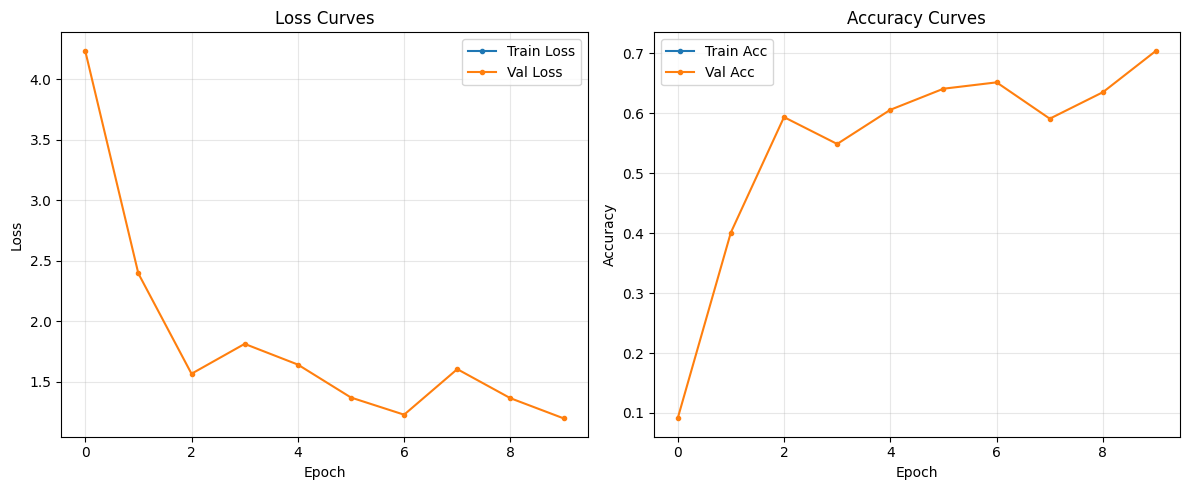

In [ ]:
run_fedavg_iid_experiment()

In [12]:
def run_fedavg_noniid_experiments():
    """
    Runs FedAvg experiments over various non-IID settings and local epochs,
    collects results, and presents them in a table and heatmap.

    Returns:
        df: DataFrame summarizing results.
    """
    config = Config()
    os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
    checkpoint_dir = os.path.join(config.CHECKPOINT_DIR, "noniid")
    os.makedirs(checkpoint_dir, exist_ok=True)
    nc_values = [1, 5, 10, 50]  # Number of classes per client (controls non-iidness)
    local_epochs_values = [4, 8, 16]  # Number of local epochs before aggregation
    results = {}

    for nc in nc_values:
        for local_epochs in local_epochs_values:
            print(f"\n=== FedAvg non-iid: nc={nc}, local_epochs={local_epochs} ===")
            checkpoint_path = os.path.join(checkpoint_dir, f"fedavg_nc{nc}_le{local_epochs}.pth")
            # Set seeds for reproducibility
            torch.manual_seed(config.RANDOM_SEED)
            np.random.seed(config.RANDOM_SEED)
            random.seed(config.RANDOM_SEED)

            # Create dataloaders with non-IID partitioning
            clients_loaders, val_loader, test_loader = get_dataloaders(config, iid=False, nc=nc)
            model = get_model(config.NUM_CLASSES, config.DEVICE)
            optimizer = torch.optim.SGD(model.parameters(), lr=config.LR, momentum=config.MOMENTUM, weight_decay=config.WEIGHT_DECAY)
            criterion = torch.nn.CrossEntropyLoss()
            best_val_acc = 0
            best_model_state = None
            val_losses, val_accs = [], []
            start_round = 0
            NUM_ROUNDS = config.EPOCHS_FEDAVG

            # Resume if checkpoint exists
            if os.path.exists(checkpoint_path):
                checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                val_losses = checkpoint['val_losses']
                val_accs = checkpoint['val_accs']
                best_val_acc = checkpoint['best_val_acc']
                best_model_state = checkpoint['best_model_state']
                start_round = checkpoint['round'] + 1

            for round_num in range(start_round, NUM_ROUNDS):
                # Randomly select fraction of clients for this round
                selected_clients = np.random.choice(
                    len(clients_loaders),
                    max(1, int(config.CLIENT_FRACTION * len(clients_loaders))),
                    replace=False
                )
                client_models = []
                # Each client trains locally
                for client_idx in selected_clients:
                    client_model = copy.deepcopy(model)
                    client_optimizer = torch.optim.SGD(
                        client_model.parameters(),
                        lr=config.LR,
                        momentum=config.MOMENTUM,
                        weight_decay=config.WEIGHT_DECAY
                    )
                    for _ in range(local_epochs):
                        train(client_model, clients_loaders[client_idx], client_optimizer, criterion, config.DEVICE)
                    client_models.append(client_model)
                # FedAvg aggregation: average client weights
                with torch.no_grad():
                    for param in model.parameters():
                        param.data.zero_()
                    for client_model in client_models:
                        for server_param, client_param in zip(model.parameters(), client_model.parameters()):
                            server_param.data += client_param.data / len(selected_clients)
                # Periodic validation and checkpointing
                if (round_num + 1) % 5 == 0 or round_num == NUM_ROUNDS - 1:
                    val_loss, val_acc = evaluate(model, val_loader, criterion, config.DEVICE)
                    val_losses.append(val_loss)
                    val_accs.append(val_acc)
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_model_state = copy.deepcopy(model.state_dict())
                    print(f"Round {round_num + 1}/{NUM_ROUNDS}: Val Acc {val_acc:.4f}")
                    torch.save({
                        'round': round_num,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_model_state': best_model_state,
                        'best_val_acc': best_val_acc,
                        'val_losses': val_losses,
                        'val_accs': val_accs,
                    }, checkpoint_path)
            # After all rounds, evaluate best model on test set
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
            test_loss, test_acc = evaluate(model, test_loader, criterion, config.DEVICE)
            print(f"Best Val Acc: {best_val_acc:.3f}")
            print(f"Test Acc: {test_acc:.3f}")
            plot_curves([], val_losses, [], val_accs, title=f"nc={nc}, local_epochs={local_epochs}")
            results[(nc, local_epochs)] = {
                "test_acc": test_acc,
                "best_val_acc": best_val_acc,
                "val_accs": val_accs,
                "val_losses": val_losses
            }
    # Present results as table and heatmap
    df = present_fedavg_noniid_results(results)
    return df

def present_fedavg_noniid_results(results, save_csv=True, csv_path="fedavg_noniid_results.csv"):
    """
    Presents the results of run_fedavg_noniid_experiments in a table and heatmap, and optionally saves as CSV.
    Args:
        results: dict, keys: (nc, local_epochs), values: dict with 'test_acc' and 'best_val_acc'.
        save_csv: whether to save as CSV.
        csv_path: output CSV path.
    Returns:
        DataFrame of results.
    """
    # Convert results dict to DataFrame
    rows = []
    for (nc, local_epochs), result in results.items():
        rows.append({
            "Classes per Client (nc)": nc,
            "Local Epochs": local_epochs,
            "Best Val Acc": result["best_val_acc"],
            "Test Acc": result["test_acc"]
        })
    df = pd.DataFrame(rows)
    df = df.sort_values(["Classes per Client (nc)", "Local Epochs"])
    print("\nFedAvg Non-IID Results Summary:")
    print(df.to_string(index=False))
    if save_csv:
        df.to_csv(csv_path, index=False)
        print(f"\nResults saved to {csv_path}")

    # Plot Heatmap of Test Accuracies
    pivot = df.pivot(index="Classes per Client (nc)", columns="Local Epochs", values="Test Acc")
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="Blues")
    plt.title("FedAvg Non-IID: Test Accuracy Heatmap")
    plt.ylabel("Classes per Client (nc)")
    plt.xlabel("Local Epochs")
    plt.tight_layout()
    plt.show()
    return df


=== FedAvg non-iid: nc=1, local_epochs=4 ===


100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Best Val Acc: 0.014
Test Acc: 0.012


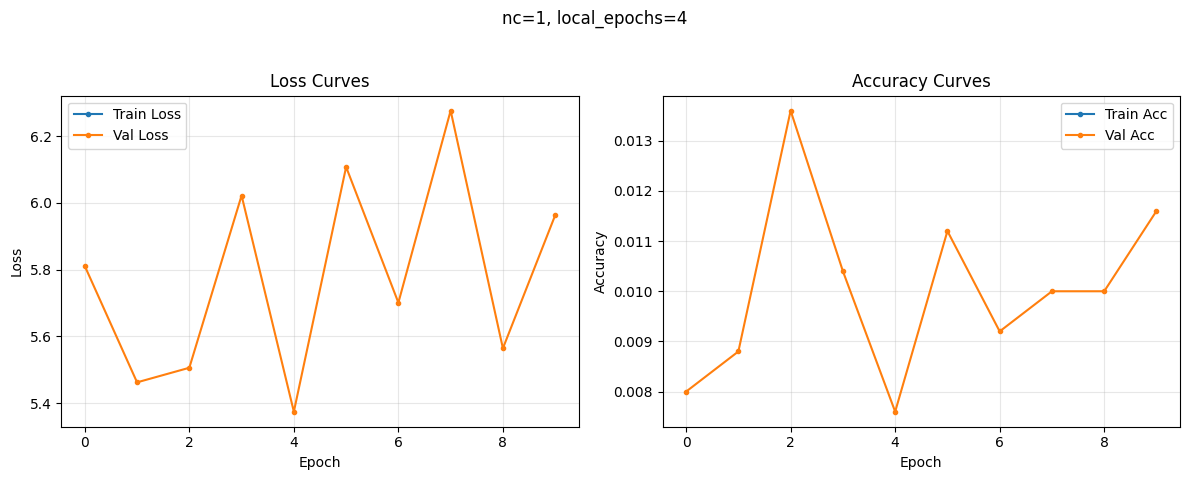


=== FedAvg non-iid: nc=1, local_epochs=8 ===
Best Val Acc: 0.012
Test Acc: 0.010


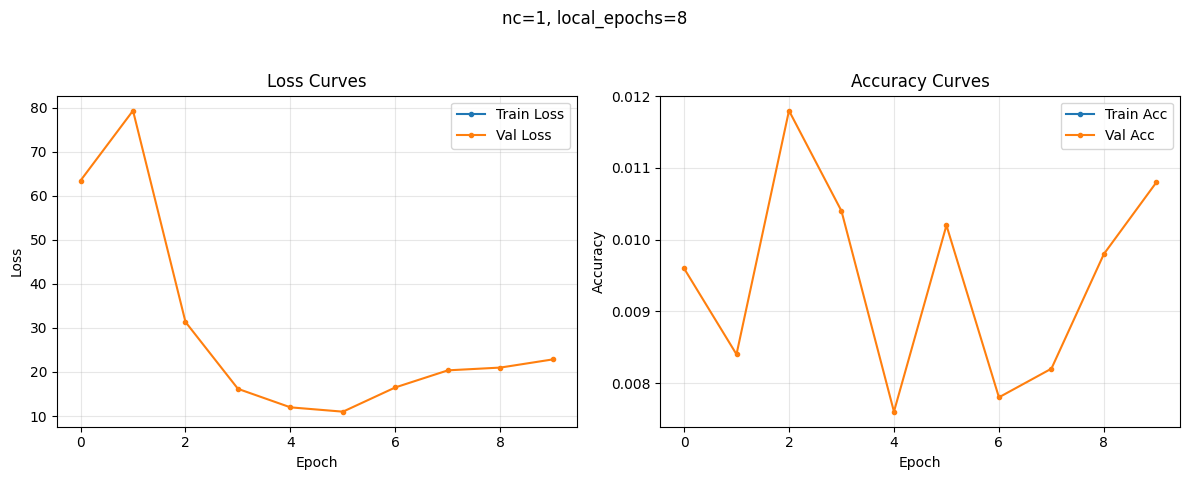


=== FedAvg non-iid: nc=1, local_epochs=16 ===
Best Val Acc: 0.011
Test Acc: 0.010


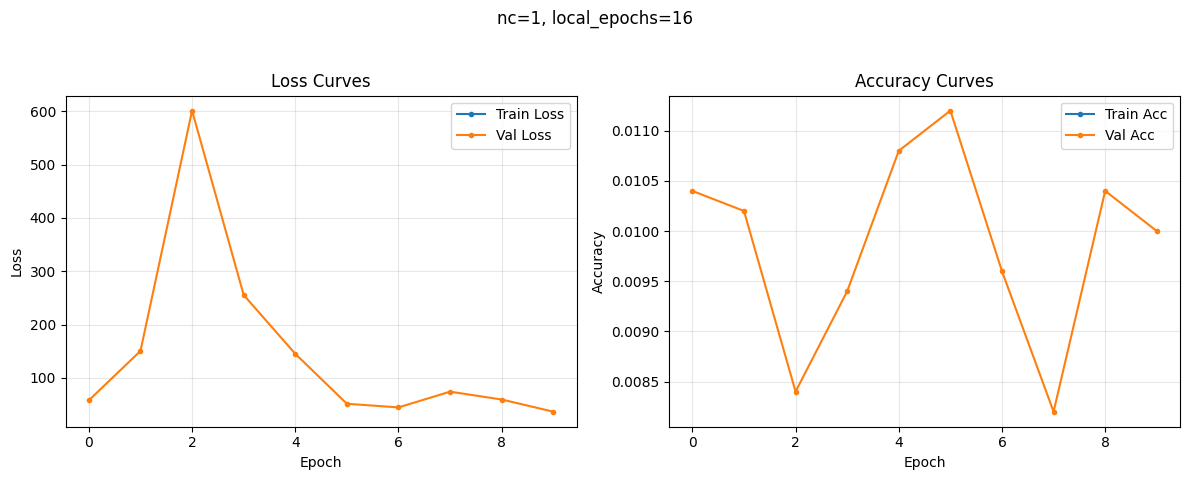


=== FedAvg non-iid: nc=5, local_epochs=4 ===
Best Val Acc: 0.740
Test Acc: 0.741


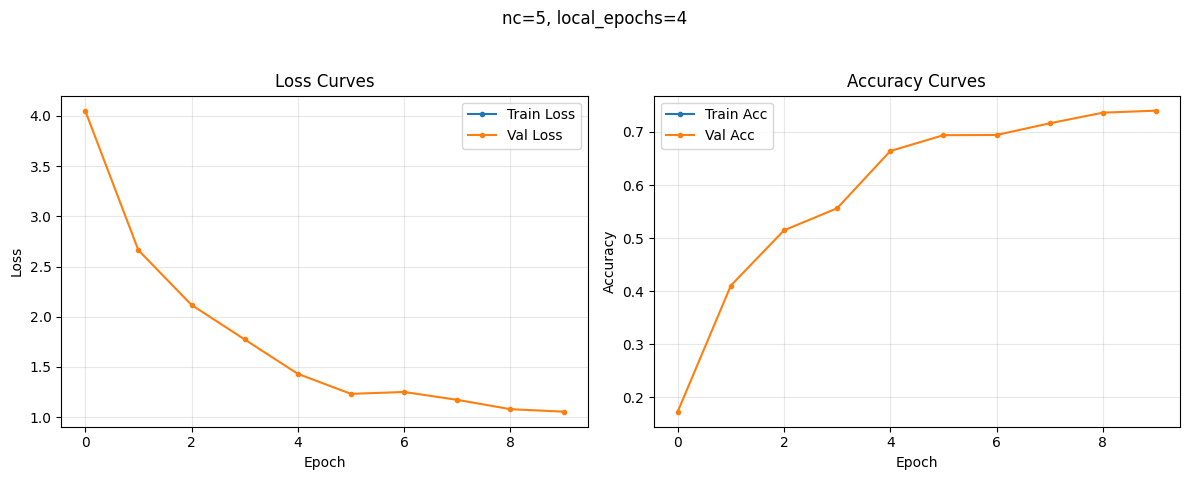


=== FedAvg non-iid: nc=5, local_epochs=8 ===
Best Val Acc: 0.410
Test Acc: 0.410


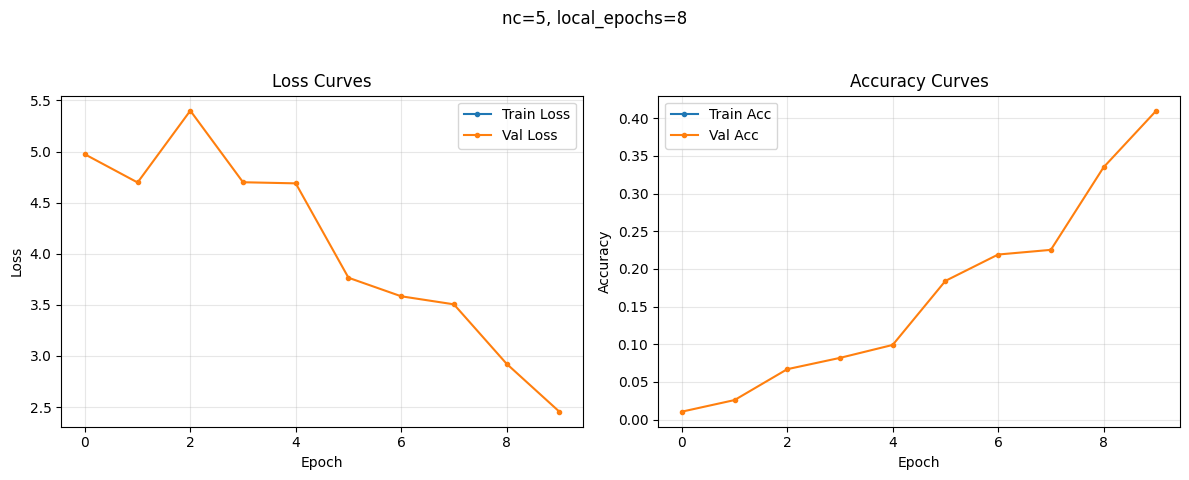


=== FedAvg non-iid: nc=5, local_epochs=16 ===
Best Val Acc: 0.066
Test Acc: 0.063


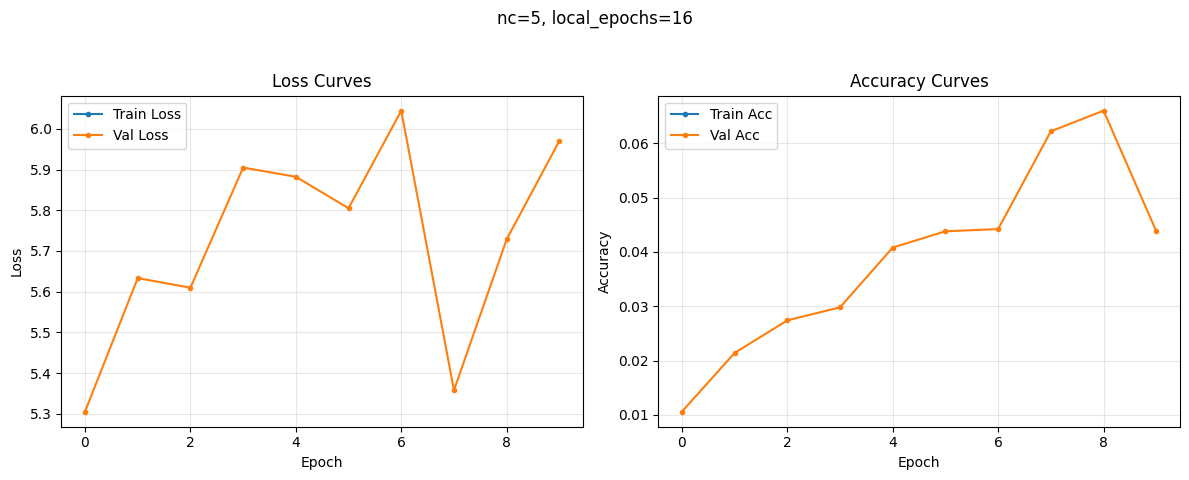


=== FedAvg non-iid: nc=10, local_epochs=4 ===
Best Val Acc: 0.830
Test Acc: 0.836


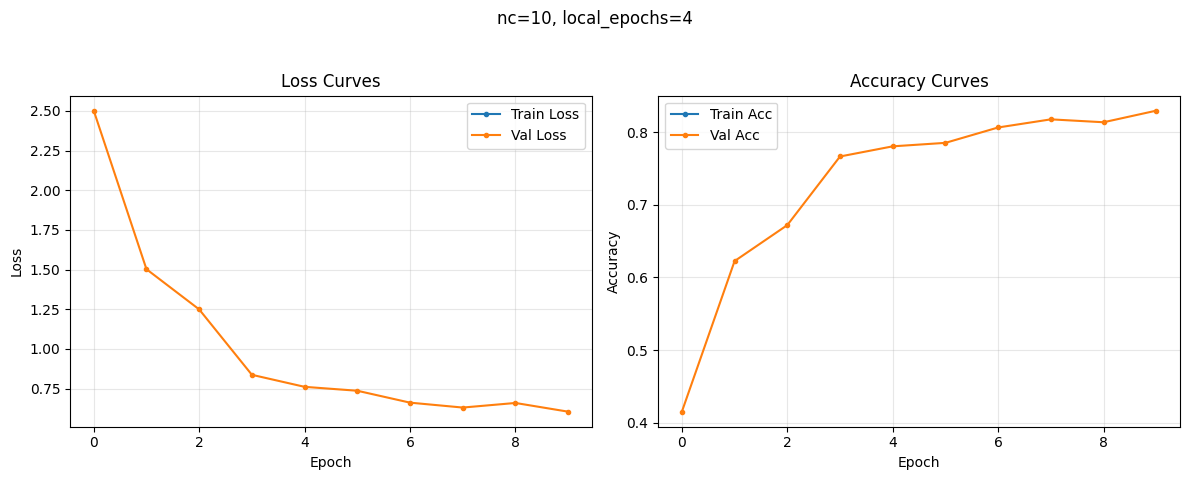


=== FedAvg non-iid: nc=10, local_epochs=8 ===
Round 45/50: Val Acc 0.7798
Round 50/50: Val Acc 0.7842
Best Val Acc: 0.788
Test Acc: 0.795


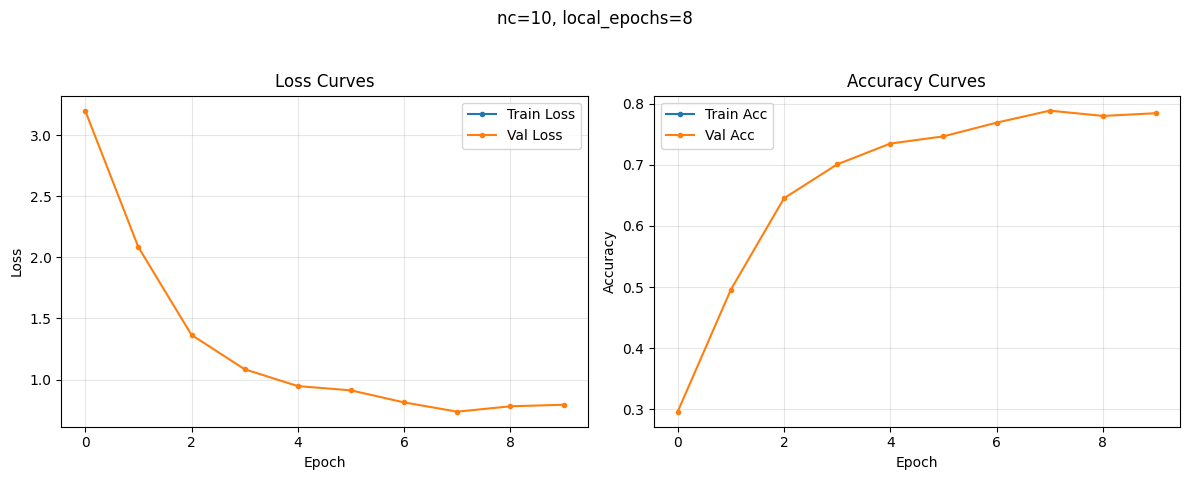


=== FedAvg non-iid: nc=10, local_epochs=16 ===
Round 5/50: Val Acc 0.0098
Round 10/50: Val Acc 0.0460
Round 15/50: Val Acc 0.0960
Round 20/50: Val Acc 0.1672
Round 25/50: Val Acc 0.2128
Round 30/50: Val Acc 0.3548
Round 35/50: Val Acc 0.3150
Round 40/50: Val Acc 0.3670
Round 45/50: Val Acc 0.4570
Round 50/50: Val Acc 0.5160
Best Val Acc: 0.516
Test Acc: 0.527


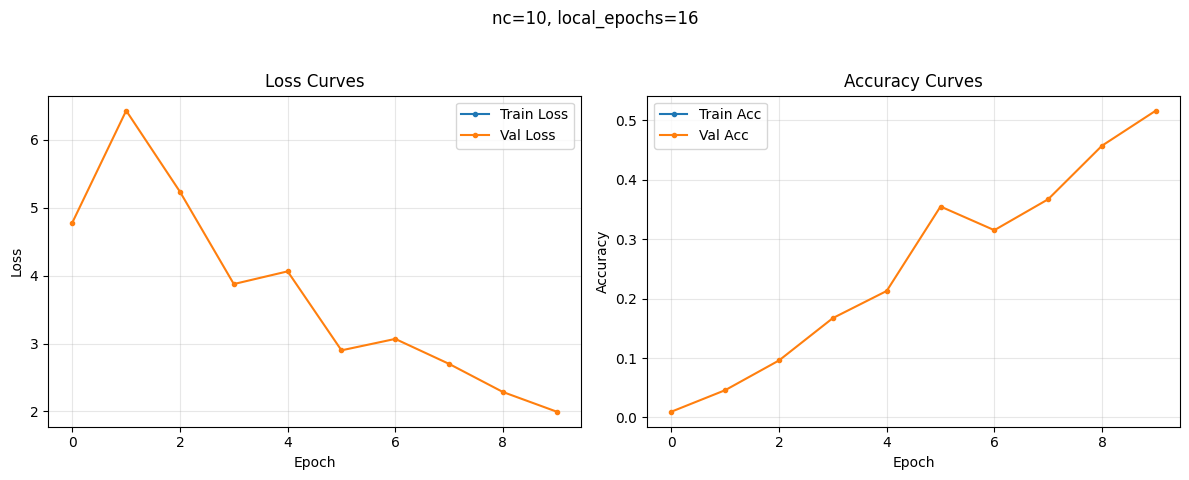


=== FedAvg non-iid: nc=50, local_epochs=4 ===
Round 5/50: Val Acc 0.6410
Round 10/50: Val Acc 0.7490
Round 15/50: Val Acc 0.7632
Round 20/50: Val Acc 0.6854
Round 25/50: Val Acc 0.7918
Round 30/50: Val Acc 0.7942
Round 35/50: Val Acc 0.8052
Round 40/50: Val Acc 0.8172
Round 45/50: Val Acc 0.8384
Round 50/50: Val Acc 0.8260
Best Val Acc: 0.838
Test Acc: 0.841


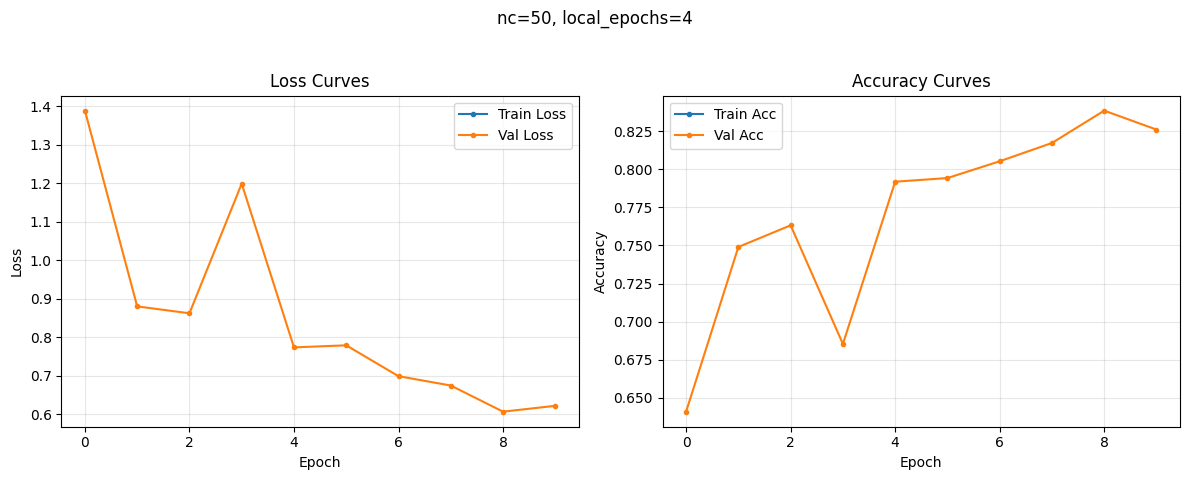


=== FedAvg non-iid: nc=50, local_epochs=8 ===
Round 5/50: Val Acc 0.4444
Round 10/50: Val Acc 0.6112
Round 15/50: Val Acc 0.1882
Round 20/50: Val Acc 0.7392
Round 25/50: Val Acc 0.7292
Round 30/50: Val Acc 0.7866
Round 35/50: Val Acc 0.7794
Round 40/50: Val Acc 0.7452
Round 45/50: Val Acc 0.7632
Round 50/50: Val Acc 0.7268
Best Val Acc: 0.787
Test Acc: 0.792


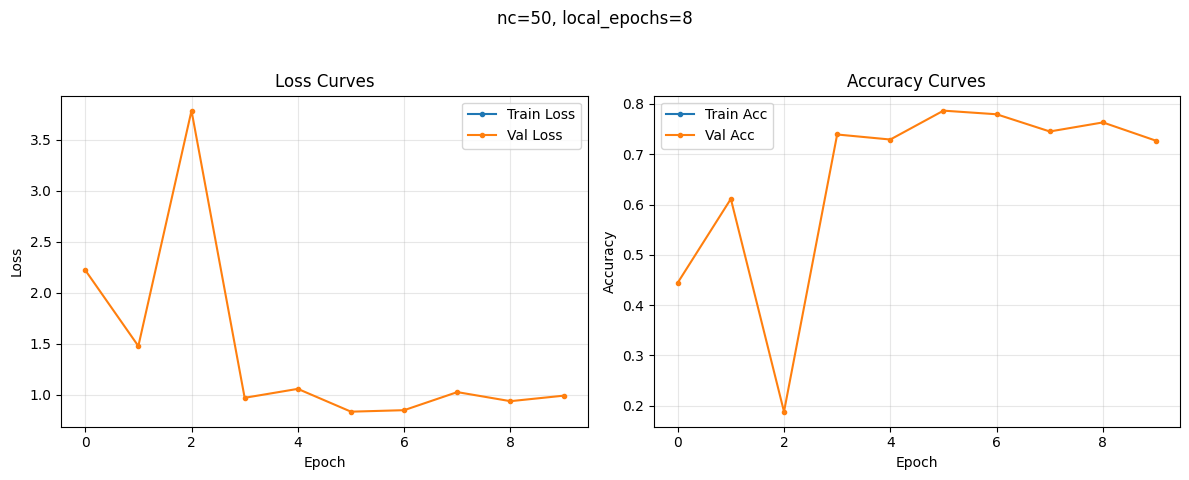


=== FedAvg non-iid: nc=50, local_epochs=16 ===
Round 5/50: Val Acc 0.3824


In [ ]:
run_fedavg_noniid_experiments()


=== FedAvg non-iid: nc=1, local_epochs=4 ===
Best Val Acc: 0.014
Test Acc: 0.012


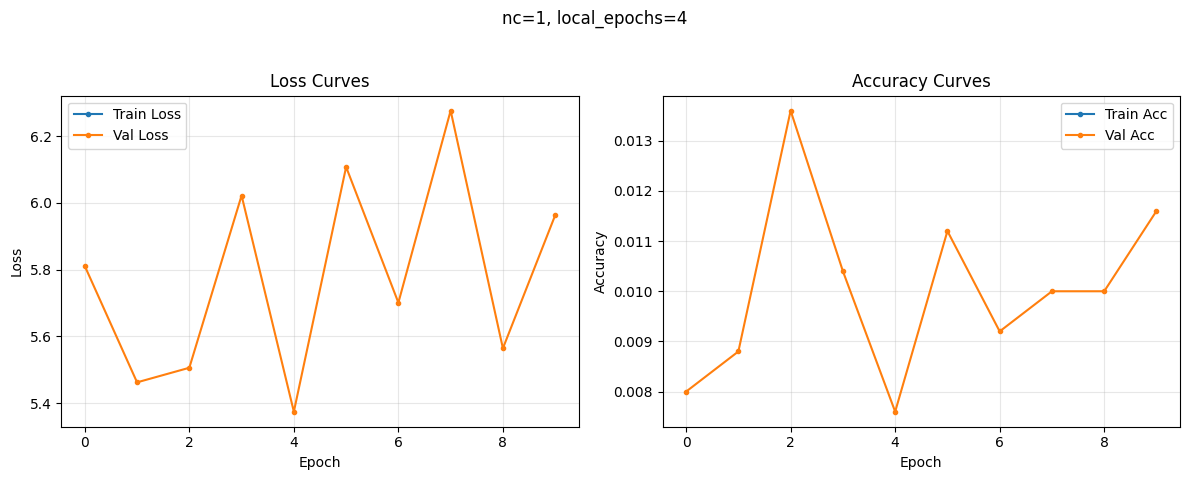


=== FedAvg non-iid: nc=1, local_epochs=8 ===
Best Val Acc: 0.012
Test Acc: 0.010


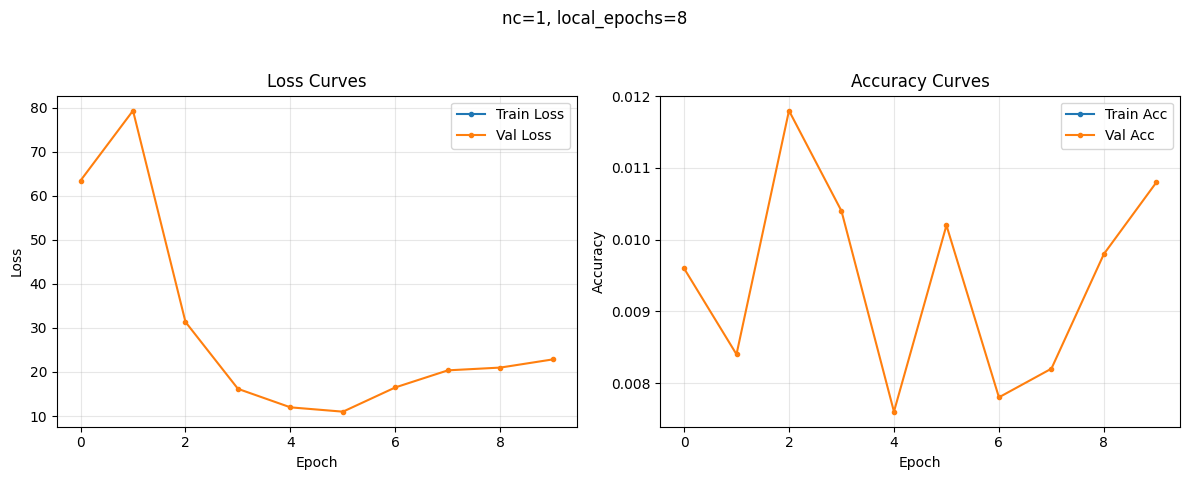


=== FedAvg non-iid: nc=1, local_epochs=16 ===
Best Val Acc: 0.011
Test Acc: 0.010


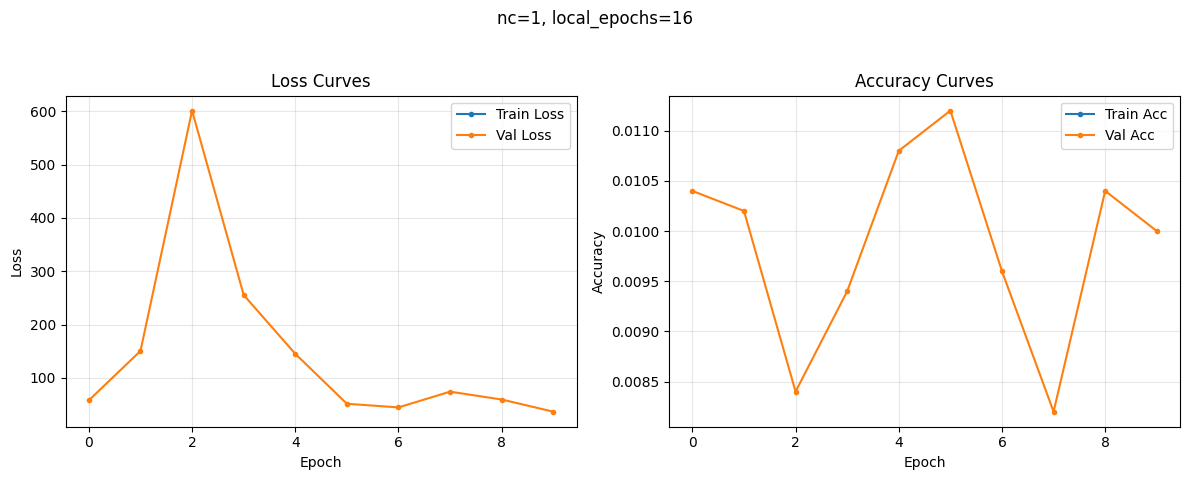


=== FedAvg non-iid: nc=5, local_epochs=4 ===
Best Val Acc: 0.740
Test Acc: 0.741


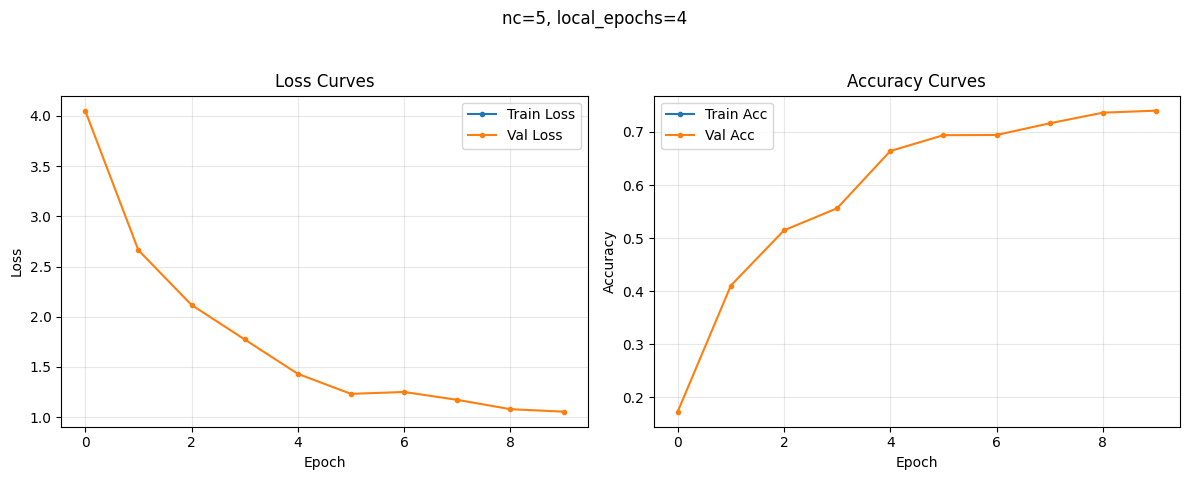


=== FedAvg non-iid: nc=5, local_epochs=8 ===
Best Val Acc: 0.410
Test Acc: 0.410


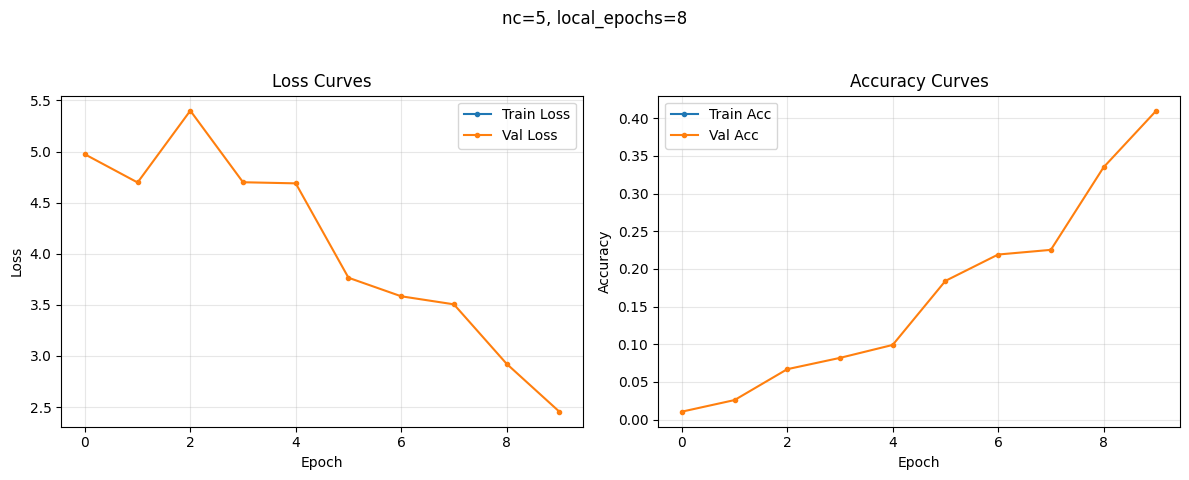


=== FedAvg non-iid: nc=5, local_epochs=16 ===
Best Val Acc: 0.066
Test Acc: 0.063


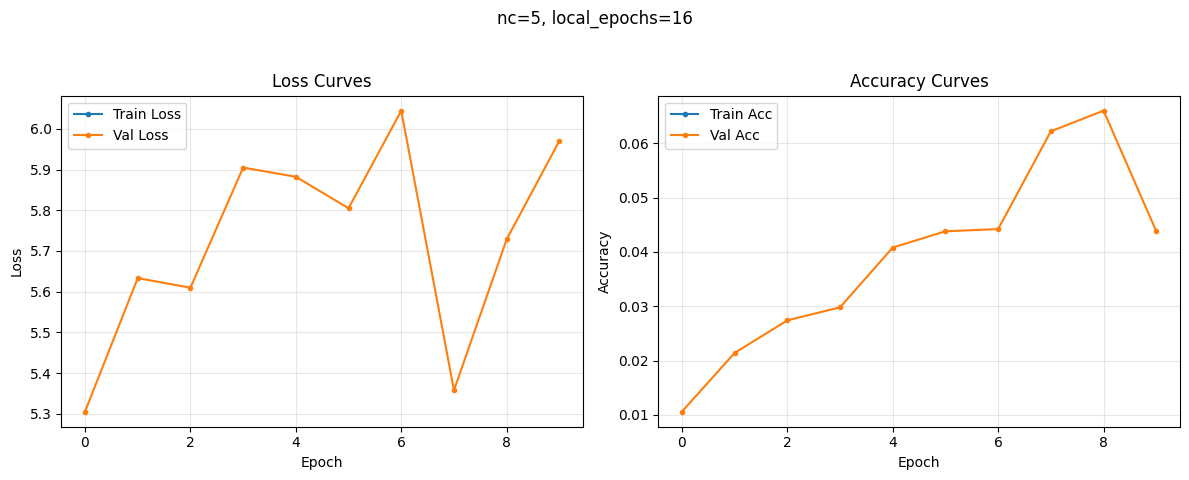


=== FedAvg non-iid: nc=10, local_epochs=4 ===
Best Val Acc: 0.830
Test Acc: 0.836


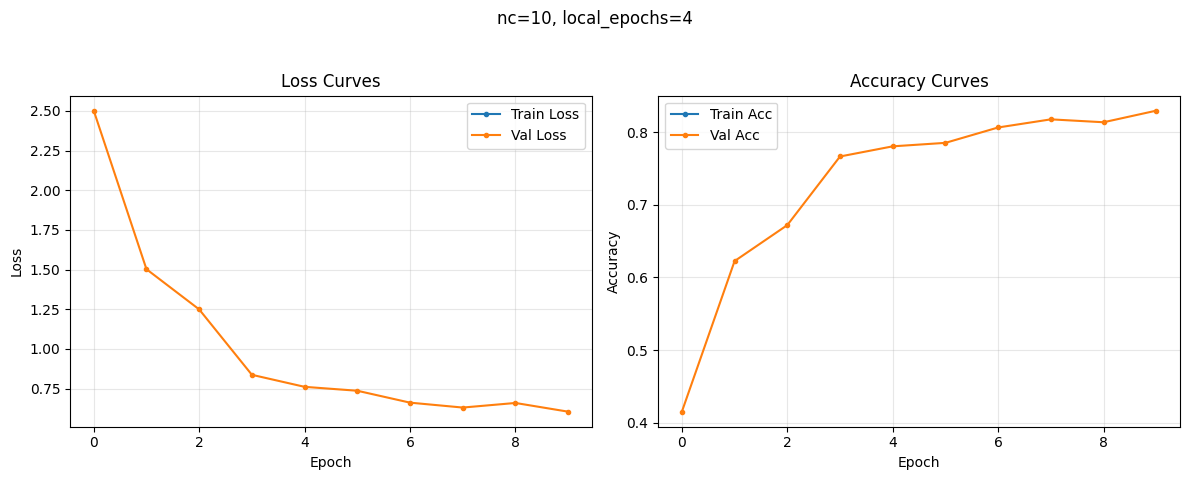


=== FedAvg non-iid: nc=10, local_epochs=8 ===
Best Val Acc: 0.788
Test Acc: 0.795


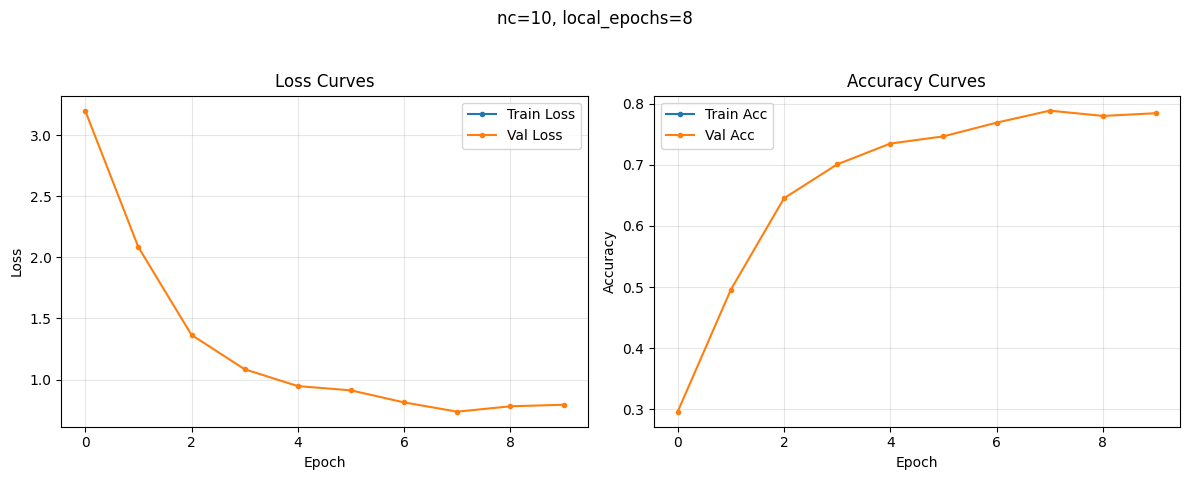


=== FedAvg non-iid: nc=10, local_epochs=16 ===
Best Val Acc: 0.516
Test Acc: 0.527


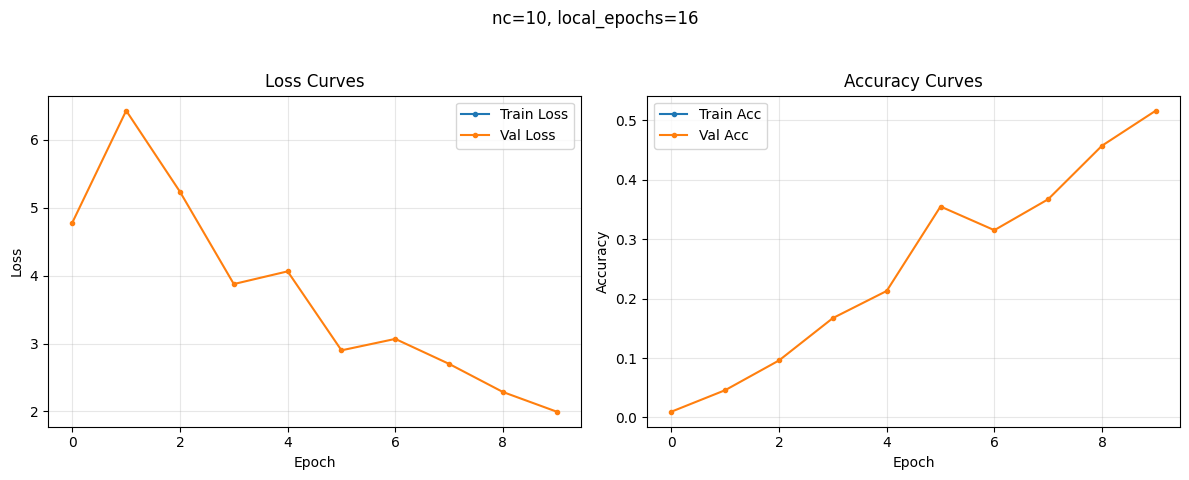


=== FedAvg non-iid: nc=50, local_epochs=4 ===
Best Val Acc: 0.838
Test Acc: 0.841


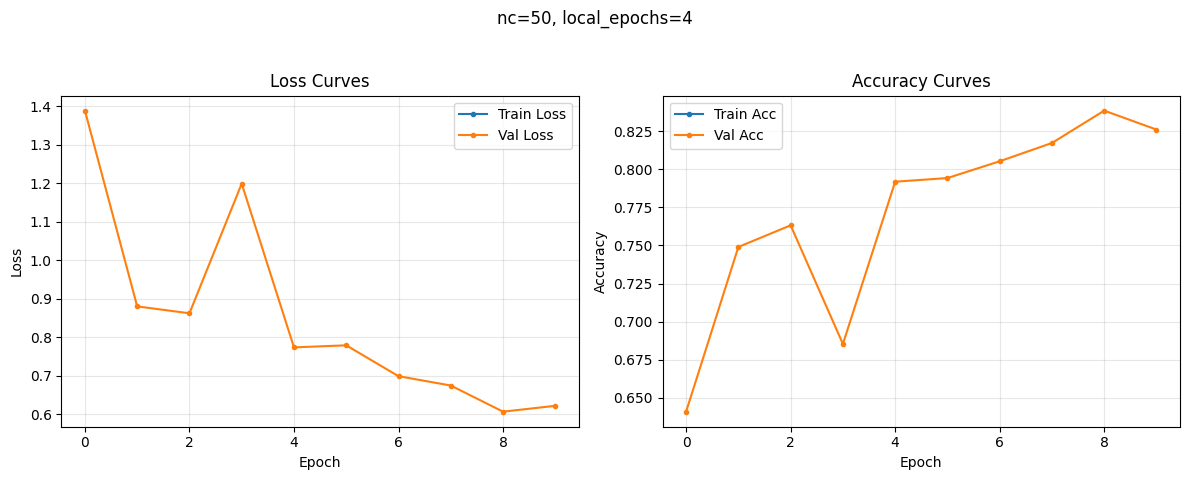


=== FedAvg non-iid: nc=50, local_epochs=8 ===
Best Val Acc: 0.787
Test Acc: 0.792


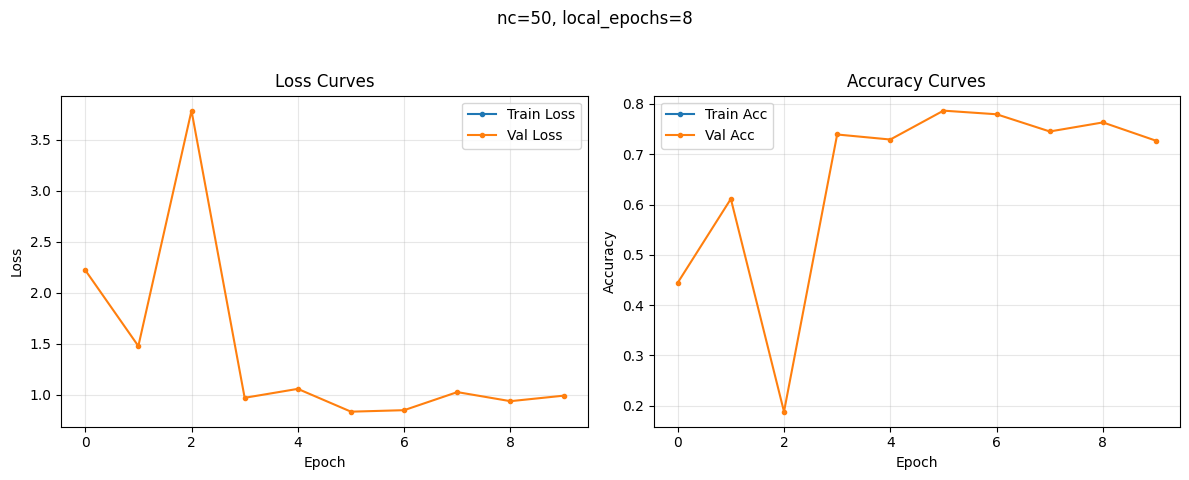


=== FedAvg non-iid: nc=50, local_epochs=16 ===
Best Val Acc: 0.676
Test Acc: 0.681


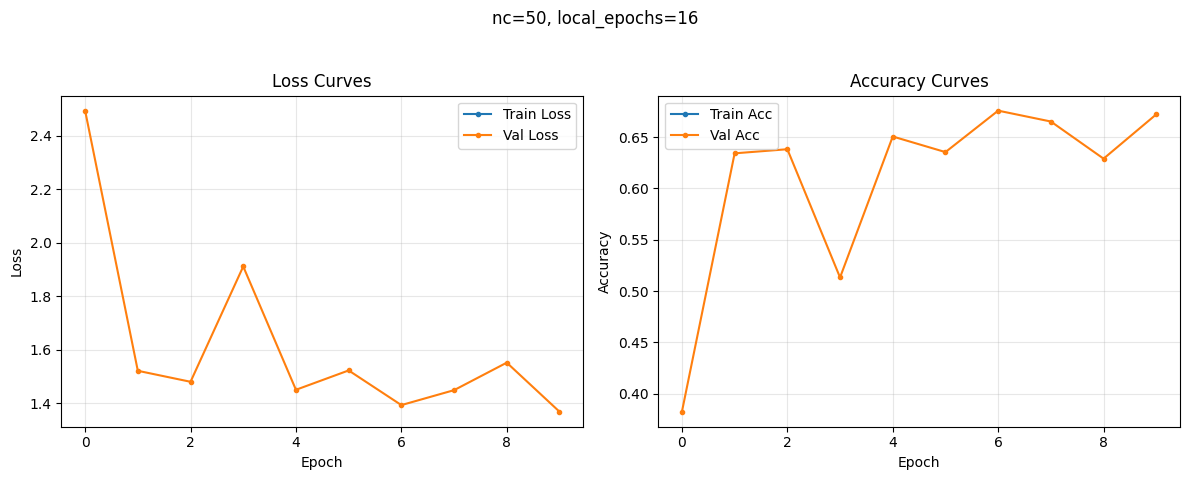


FedAvg Non-IID Results Summary:
 Classes per Client (nc)  Local Epochs  Best Val Acc  Test Acc
                       1             4        0.0136    0.0122
                       1             8        0.0118    0.0100
                       1            16        0.0112    0.0100
                       5             4        0.7400    0.7405
                       5             8        0.4102    0.4101
                       5            16        0.0660    0.0630
                      10             4        0.8300    0.8356
                      10             8        0.7884    0.7951
                      10            16        0.5160    0.5267
                      50             4        0.8384    0.8408
                      50             8        0.7866    0.7919
                      50            16        0.6758    0.6813

Results saved to fedavg_noniid_results.csv


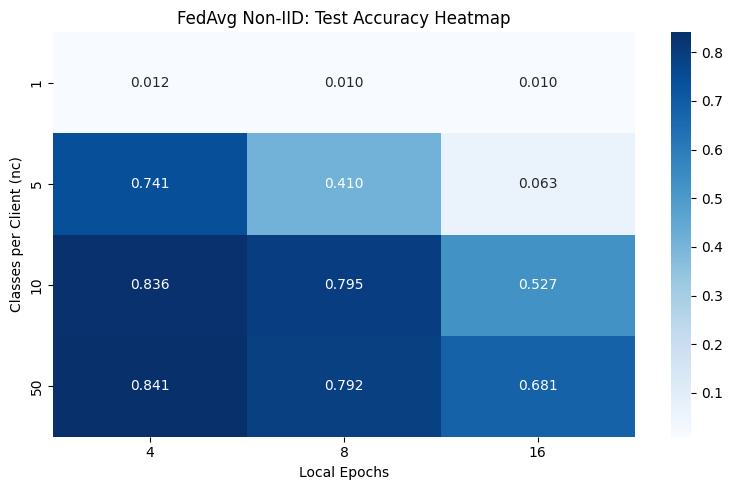

,Classes per Client (nc),Local Epochs,Best Val Acc,Test Acc
0,1,4,0.0136,0.0122
1,1,8,0.0118,0.0100
2,1,16,0.0112,0.0100
3,5,4,0.7400,0.7405
4,5,8,0.4102,0.4101
5,5,16,0.0660,0.0630
6,10,4,0.8300,0.8356
7,10,8,0.7884,0.7951
8,10,16,0.5160,0.5267
9,50,4,0.8384,0.8408


In [13]:
run_fedavg_noniid_experiments()

In [10]:
def run_sparse_experiments(plot_mode="best", save_csv=True, csv_path="sparse_experiment_results.csv"):
    """
    Runs sparse training experiments, varying method and sparsity.
    Presents results as a table, saves as CSV, and plots learning curves only for the best run (or other option).

    Args:
        plot_mode (str): "best" (default, plot only best run curves), "all" (plot all runs), "none" (no plots).
        save_csv (bool): If True, saves results as csv.
        csv_path (str): Path to save csv file.

    Returns:
        results (list): list of dicts, each with 'method', 'sparsity', 'accuracy'.
    """
    config = Config()
    os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
    checkpoint_dir = os.path.join(config.CHECKPOINT_DIR, "sparse")
    os.makedirs(checkpoint_dir, exist_ok=True)
    methods = ['least-sensitive', 'most-sensitive', 'low-magnitude', 'high-magnitude', 'random', 'hybrid']
    sparsity_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
    results = []

    # --- Use full training/validation/test sets (not federated partitions) ---
    transform_train, transform_test = get_transforms()
    full_trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    trainset, valset = split_dataset(full_trainset, val_split=config.VAL_SPLIT)
    train_loader = DataLoader(trainset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY)
    val_loader = DataLoader(valset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY)
    test_loader = DataLoader(testset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY)
    criterion = torch.nn.CrossEntropyLoss()

    best_result = None
    best_acc = -float('inf')
    best_curves = None

    for method in methods:
        method_dir = os.path.join(checkpoint_dir, method)
        os.makedirs(method_dir, exist_ok=True)
        for sparsity in sparsity_ratios:
            print(f"\nMethod: {method}, Sparsity: {sparsity}")
            ckpt_path = os.path.join(method_dir, f"sparsity_{sparsity}.pt")
            model = get_model(config.NUM_CLASSES, config.DEVICE)

            # Use full training loader for mask calibration!
            if method == 'hybrid':
                mask = hybrid_mask(model, train_loader, config.DEVICE, sparsity=sparsity, alpha=0.5)
            else:
                mask = calibrate_mask(model, train_loader, config.DEVICE, method=method, sparsity=sparsity)

            optimizer = SparseSGDM(model.parameters(), lr=config.LR, momentum=config.MOMENTUM,
                                   weight_decay=config.WEIGHT_DECAY, mask=mask)
            start_epoch = 0
            if os.path.exists(ckpt_path):
                checkpoint = torch.load(ckpt_path, map_location=config.DEVICE)
                model.load_state_dict(checkpoint['model_state'])
                optimizer.load_state_dict(checkpoint['optimizer_state'])
                start_epoch = checkpoint['epoch'] + 1

            train_losses, val_losses, train_accs, val_accs = [], [], [], []
            for epoch in range(start_epoch, 5):
                trl, tra = train(model, train_loader, optimizer, criterion, config.DEVICE)  # Use full train_loader
                vall, vala = evaluate(model, val_loader, criterion, config.DEVICE)
                train_losses.append(trl)
                val_losses.append(vall)
                train_accs.append(tra)
                val_accs.append(vala)
                print(f"Epoch {epoch}: Train Acc {tra:.3f}, Val Acc {vala:.3f}")
                torch.save({
                    'epoch': epoch,
                    'model_state': model.state_dict(),
                    'optimizer_state': optimizer.state_dict()
                }, ckpt_path)

            tloss, tacc = evaluate(model, test_loader, criterion, config.DEVICE)
            print(f"Test Accuracy for method {method}, sparsity {sparsity}: {tacc:.3f}")
            results.append({'method': method, 'sparsity': sparsity, 'accuracy': tacc})

            # Track the best run and plot if needed
            if tacc > best_acc:
                best_acc = tacc
                best_result = {'method': method, 'sparsity': sparsity, 'accuracy': tacc}
                best_curves = (train_losses, val_losses, train_accs, val_accs)
            if plot_mode == "all":
                plot_curves(train_losses, val_losses, train_accs, val_accs)

    # Present results as DataFrame
    df = pd.DataFrame(results)
    df_pivot = df.pivot(index="method", columns="sparsity", values="accuracy")
    print("\nSparse Experiment Results (Test Accuracy):")
    print(df_pivot.round(3))

    if save_csv:
        df_pivot.to_csv(csv_path)
        print(f"\nResults saved to {csv_path}")

    if plot_mode == "best" and best_curves is not None:
        print(f"\nBest result: {best_result}")
        plot_curves(*best_curves)
    return results


Method: least-sensitive, Sparsity: 0.1
Epoch 0: Train Acc 0.708, Val Acc 0.819
Epoch 1: Train Acc 0.830, Val Acc 0.796
Epoch 2: Train Acc 0.787, Val Acc 0.699
Epoch 3: Train Acc 0.707, Val Acc 0.575
Epoch 4: Train Acc 0.619, Val Acc 0.489
Test Accuracy for method least-sensitive, sparsity 0.1: 0.500

Method: least-sensitive, Sparsity: 0.3
Epoch 0: Train Acc 0.711, Val Acc 0.790
Epoch 1: Train Acc 0.804, Val Acc 0.731
Epoch 2: Train Acc 0.779, Val Acc 0.694
Epoch 3: Train Acc 0.738, Val Acc 0.667
Epoch 4: Train Acc 0.694, Val Acc 0.597
Test Accuracy for method least-sensitive, sparsity 0.3: 0.613

Method: least-sensitive, Sparsity: 0.5
Epoch 0: Train Acc 0.682, Val Acc 0.744
Epoch 1: Train Acc 0.781, Val Acc 0.724
Epoch 2: Train Acc 0.770, Val Acc 0.710
Epoch 3: Train Acc 0.747, Val Acc 0.655
Epoch 4: Train Acc 0.723, Val Acc 0.596
Test Accuracy for method least-sensitive, sparsity 0.5: 0.609

Method: least-sensitive, Sparsity: 0.7
Epoch 0: Train Acc 0.637, Val Acc 0.711
Epoch 1: Train

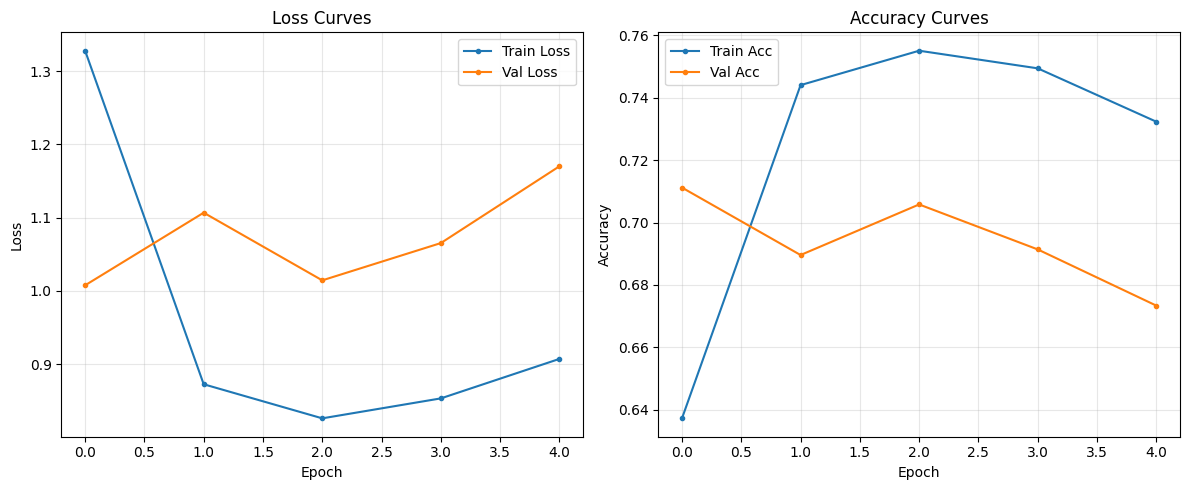

[{'method': 'least-sensitive', 'sparsity': 0.1, 'accuracy': 0.5001},
 {'method': 'least-sensitive', 'sparsity': 0.3, 'accuracy': 0.6126},
 {'method': 'least-sensitive', 'sparsity': 0.5, 'accuracy': 0.6094},
 {'method': 'least-sensitive', 'sparsity': 0.7, 'accuracy': 0.6901},
 {'method': 'least-sensitive', 'sparsity': 0.9, 'accuracy': 0.6544},
 {'method': 'most-sensitive', 'sparsity': 0.1, 'accuracy': 0.5956},
 {'method': 'most-sensitive', 'sparsity': 0.3, 'accuracy': 0.6402},
 {'method': 'most-sensitive', 'sparsity': 0.5, 'accuracy': 0.6119},
 {'method': 'most-sensitive', 'sparsity': 0.7, 'accuracy': 0.6362},
 {'method': 'most-sensitive', 'sparsity': 0.9, 'accuracy': 0.6513},
 {'method': 'low-magnitude', 'sparsity': 0.1, 'accuracy': 0.4945},
 {'method': 'low-magnitude', 'sparsity': 0.3, 'accuracy': 0.6031},
 {'method': 'low-magnitude', 'sparsity': 0.5, 'accuracy': 0.6272},
 {'method': 'low-magnitude', 'sparsity': 0.7, 'accuracy': 0.6684},
 {'method': 'low-magnitude', 'sparsity': 0.9, '

In [15]:
run_sparse_experiments(plot_mode="best", save_csv=True, csv_path="sparse_experiment_results.csv")

In [ ]:
from google.colab import files
files.download('sparse_experiment_results.csv')

In [11]:
def mask_overlap_analysis(num_clients=5, seed=42, plot=True, save_csv=True, csv_path="mask_overlap_results.csv"):
    """
    Computes and presents the pairwise Jaccard overlap (intersection/union) between masks generated for different clients,
    across various mask calibration methods and sparsity levels.

    Args:
        num_clients (int): Number of clients to consider.
        seed (int): Random seed for reproducibility.
        plot (bool): If True, displays a heatmap of the results.
        save_csv (bool): If True, saves the results as a CSV file.
        csv_path (str): Path to save the CSV file.

    Returns:
        overlaps (dict): mapping (method, sparsity) -> average pairwise Jaccard index (float)
    """
    # Set seeds ONCE for overall experiment reproducibility (not inside the client loop)
    torch.manual_seed(seed)
    np.random.seed(seed)

    config = Config()
    clients_loaders, _, _ = get_dataloaders(config, iid=False, nc=config.NC)
    method_list = ['least-sensitive', 'most-sensitive', 'low-magnitude', 'high-magnitude', 'random']
    ratio_list = [0.1, 0.3, 0.5, 0.7, 0.9]
    overlaps = {}
    print("Computing mask overlaps...")

    for method in method_list:
        for sparsity in ratio_list:
            masks = []
            for client_idx, loader in enumerate(clients_loaders[:num_clients]):
                model = get_model(config.NUM_CLASSES, config.DEVICE)
                # For 'random', use a different seed per client for true randomness
                if method == "random":
                    mask = calibrate_mask(
                        model, loader, config.DEVICE,
                        method=method,
                        sparsity=sparsity,
                        seed=seed + client_idx  # Different seed for each client
                    )
                else:
                    mask = calibrate_mask(
                        model, loader, config.DEVICE,
                        method=method,
                        sparsity=sparsity,
                        seed=seed  # Same seed for all non-random methods
                    )
                masks.append(mask)
            # Compute all pairwise Jaccard indices
            jaccs = []
            for i in range(len(masks)):
                for j in range(i + 1, len(masks)):
                    mask1 = torch.cat([m.flatten() for m in masks[i]])
                    mask2 = torch.cat([m.flatten() for m in masks[j]])
                    intersection = (mask1 * mask2).sum().item()
                    union = ((mask1 + mask2) > 0).sum().item()
                    jaccs.append(intersection / union if union > 0 else 0)
            overlaps[(method, sparsity)] = float(np.mean(jaccs)) if jaccs else 0.0
            print(f"Method: {method:>15}, Sparsity: {sparsity:.1f}, Avg Jaccard: {overlaps[(method, sparsity)]:.3f}")

    # Convert to DataFrame for presentation
    records = []
    for (method, sparsity), jacc in overlaps.items():
        records.append({"Method": method, "Sparsity": sparsity, "Avg_Jaccard": jacc})
    df = pd.DataFrame(records)
    df_pivot = df.pivot(index="Method", columns="Sparsity", values="Avg_Jaccard")
    print("\nMask Overlap (Average Jaccard Index):")
    print(df_pivot.round(3))

    if save_csv:
        df_pivot.to_csv(csv_path)
        print(f"\nResults saved to {csv_path}")

    if plot:
        plt.figure(figsize=(8, 5))
        sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Average Jaccard Index between Client Masks")
        plt.ylabel("Method")
        plt.xlabel("Sparsity")
        plt.tight_layout()
        plt.show()

    return overlaps

100%|██████████| 169M/169M [00:05<00:00, 28.3MB/s]


Computing mask overlaps...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Method: least-sensitive, Sparsity: 0.1, Avg Jaccard: 0.096
Method: least-sensitive, Sparsity: 0.3, Avg Jaccard: 0.256
Method: least-sensitive, Sparsity: 0.5, Avg Jaccard: 0.433
Method: least-sensitive, Sparsity: 0.7, Avg Jaccard: 0.632
Method: least-sensitive, Sparsity: 0.9, Avg Jaccard: 0.859
Method:  most-sensitive, Sparsity: 0.1, Avg Jaccard: 0.187
Method:  most-sensitive, Sparsity: 0.3, Avg Jaccard: 0.310
Method:  most-sensitive, Sparsity: 0.5, Avg Jaccard: 0.433
Method:  most-sensitive, Sparsity: 0.7, Avg Jaccard: 0.595
Method:  most-sensitive, Sparsity: 0.9, Avg Jaccard: 0.832
Method:   low-magnitude, Sparsity: 0.1, Avg Jaccard: 0.096
Method:   low-magnitude, Sparsity: 0.3, Avg Jaccard: 0.256
Method:   low-magnitude, Sparsity: 0.5, Avg Jaccard: 0.433
Method:   low-magnitude, Sparsity: 0.7, Avg Jaccard: 0.632
Method:   low-magnitude, Sparsity: 0.9, Avg Jaccard: 0.859
Method:  high-magnitude, Sparsity: 0.1, Avg Jaccard: 0.187
Method:  high-magnitude, Sparsity: 0.3, Avg Jaccard: 0.3

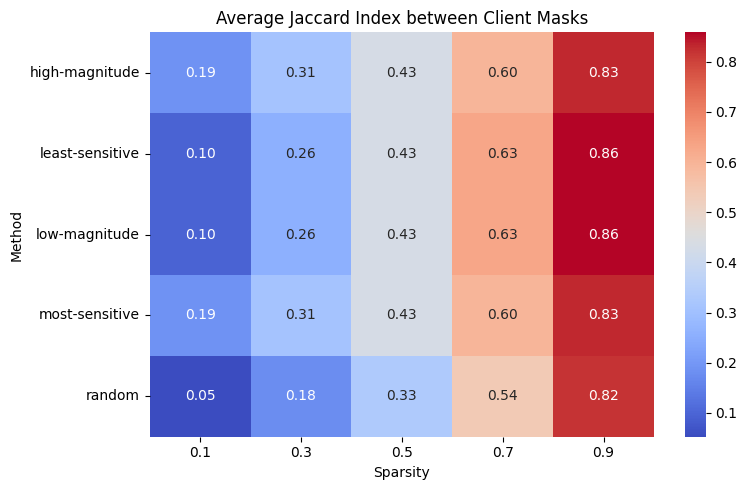

{('least-sensitive', 0.1): 0.09562847295649504,
 ('least-sensitive', 0.3): 0.2562275475453942,
 ('least-sensitive', 0.5): 0.4333066375242319,
 ('least-sensitive', 0.7): 0.6316782987901679,
 ('least-sensitive', 0.9): 0.8585635087722817,
 ('most-sensitive', 0.1): 0.18704547836986213,
 ('most-sensitive', 0.3): 0.3100174916528117,
 ('most-sensitive', 0.5): 0.4333066375242319,
 ('most-sensitive', 0.7): 0.5952192558650431,
 ('most-sensitive', 0.9): 0.831987144050197,
 ('low-magnitude', 0.1): 0.09566958237362566,
 ('low-magnitude', 0.3): 0.25622753546539706,
 ('low-magnitude', 0.5): 0.4333066375242319,
 ('low-magnitude', 0.7): 0.6316782987901679,
 ('low-magnitude', 0.9): 0.8585635087722817,
 ('high-magnitude', 0.1): 0.18704547836986213,
 ('high-magnitude', 0.3): 0.3100174916528117,
 ('high-magnitude', 0.5): 0.43330665645581423,
 ('high-magnitude', 0.7): 0.5952192642082501,
 ('high-magnitude', 0.9): 0.8319870698846152,
 ('random', 0.1): 0.052558838526735006,
 ('random', 0.3): 0.176439779836679

In [12]:
mask_overlap_analysis(num_clients=5, seed=42, plot=True, save_csv=True, csv_path="mask_overlap_results.csv")

In [15]:
from google.colab import files
files.download('mask_overlap_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>